In [1]:
import pandas as pd
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, TensorDataset, random_split
from tqdm import tqdm

# Specify the path to your CSV file
csv_file_path = "trajectories-0400-0415.csv"

# Use pandas to read the CSV file into a DataFrame
chunk_size = 100000  # Adjust this according to your system's memory capacity
dataframes = []
for chunk in pd.read_csv(csv_file_path, chunksize=chunk_size):
    dataframes.append(chunk)

# Concatenate all the chunks into one DataFrame
df = pd.concat(dataframes, ignore_index=True)
df['Unique_ID'] = df['Vehicle_ID'].astype(str) + df['Total_Frames'].astype(str)

# Create an empty dictionary to store DataFrames
dataframes_dict = {}

# Group the DataFrame by the common column
grouped = df.groupby('Unique_ID')

# Iterate over groups and store each group as a separate DataFrame in the dictionary
for group_name, group_df in grouped:
    dataframes_dict[group_name] = group_df


In [2]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, seq_len, dropout=0.1):
        super(TimeSeriesTransformer, self).__init__()
        self.d_model = d_model
        self.seq_len = seq_len
        self.embedding = nn.Linear(input_dim, d_model)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        
        self.positional_encoding = self._generate_positional_encoding(d_model)
        self.output_layer = nn.Linear(d_model, 1)  # predicting two values: v_Vel and v_Acc
        
    def forward(self, src):
        src = self.embedding(src) * torch.sqrt(torch.tensor(self.d_model))
        pe = self._generate_positional_encoding(src.size(0))  # generate positional encoding dynamically
        src += pe
        output = self.transformer_encoder(src)
        output = self.output_layer(output[:, -1, :])
        return output
    
    def _generate_positional_encoding(self, batch_size):
        position = torch.arange(0, self.seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, self.d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / self.d_model))
        pe = torch.zeros(self.seq_len, self.d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).repeat(batch_size, 1, 1)
        return pe

input_dim = 3  # The number of input features
nhead = 8  # The number of heads in the multi-head attention models
num_encoder_layers = 6  # The number of sub-encoder-layers in the encoder
dim_feedforward = 2048  # The dimension of the feedforward network model
dropout = 0.1  # The dropout value
sequence_length=10
# Ensure d_model is divisible by nhead
d_model = 8 * nhead

model_transformer = TimeSeriesTransformer(
    input_dim=input_dim,
    d_model=d_model,
    nhead=nhead,
    num_encoder_layers=num_encoder_layers,
    dim_feedforward=dim_feedforward,
    dropout=dropout,
    seq_len=sequence_length
)


LSTM

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

input_size=input_dim
hidden_size = 64
num_layers = 2
output_size = 1
num_epochs = 100
learning_rate = 0.001

model_lstm = LSTM(input_size, hidden_size, num_layers, output_size).to(device)

In [4]:
def create_sequences(input_data, target_data, sequence_length):
    sequences = []
    targets = []
    for i in range(len(input_data) - sequence_length):
        seq = input_data[i:i+sequence_length]  # Sequence of features
        target = target_data[i+sequence_length]  # Next step's features
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

In [5]:
losses_val=[]
model=model_transformer
for Car_ID in dataframes_dict.keys():
    
    df2=dataframes_dict[Car_ID]
    df2=df2[['Local_X','Local_Y','Lane_ID','Preceding','Following','v_Vel']]
    normalized_data = (df2 - df2.mean()) / df2.std()
    feature_columns = ['Local_X', 'Local_Y', 'v_Vel']
    target_columns = ['v_Vel']

    # Create sequences
    sequence_length = 10  # For example, using the last 10 timesteps to predict the next

    # Convert DataFrame to numpy and split features and target
    feature_data = normalized_data[feature_columns].values
    target_data = normalized_data[target_columns].values

    sequences, targets = create_sequences(feature_data, target_data, sequence_length)

    # 3. Split the Data (for example, 80-10-10 split)
    train_size = int(len(sequences) * 0.9)
    val_size = int(len(sequences) * 0.1)

    train_sequences, train_targets = sequences[:train_size], targets[:train_size]
    val_sequences, val_targets = sequences[train_size:train_size+val_size], targets[train_size:train_size+val_size]
    test_sequences, test_targets = sequences[train_size+val_size:], targets[train_size+val_size:]

    # 4. Convert to Tensors
    train_sequences = torch.tensor(train_sequences, dtype=torch.float16)
    train_targets = torch.tensor(train_targets, dtype=torch.float16)
    val_sequences = torch.tensor(val_sequences, dtype=torch.float16)
    val_targets = torch.tensor(val_targets, dtype=torch.float16)
    test_sequences = torch.tensor(test_sequences, dtype=torch.float16)
    test_targets = torch.tensor(test_targets, dtype=torch.float16)

    loss_function = torch.nn.MSELoss()  # Mean Squared Error Loss for regression tasks
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)  # Adam optimizer

    # Convert the sequences and targets into PyTorch Dataset and DataLoader
    train_data = TensorDataset(train_sequences, train_targets)
    val_data = TensorDataset(val_sequences, val_targets)

    # Dataloader allows batch processing of the dataset
    batch_size = 64
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

    # Training Loop
    num_epochs = 1  # You can adjust this number as needed
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        train_losses = []
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
        total_iterations = len(train_loader)
        for batch_idx, (seq, target) in enumerate(progress_bar):
            optimizer.zero_grad()  # Clear the gradients
            seq = seq.float()
            target = target.float()
            output = model(seq)  # Forward pass: compute the output
            loss = loss_function(output, target)  # Compute the loss
            loss.backward()  # Backward pass: compute the gradient
            optimizer.step()  # Update the parameters
            train_losses.append(loss.item())  # Record the loss
            
            # Calculate remaining iterations and update progress bar
            remaining_iterations = len(train_loader) - len(train_losses)
            progress_bar.set_postfix(Loss=loss.item(), Remaining=remaining_iterations)

        # Validation Loop
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():  # No gradients required for validation
            val_losses = []
            for seq, target in val_loader:
                seq = seq.float()
                target = target.float()
                output = model(seq)  # Compute the model output
                loss = loss_function(output, target)  # Compute the loss
                val_losses.append(loss.item())  # Record the loss
        losses_val.append(val_losses)
        print(f"Epoch {epoch+1}, Training Loss: {np.mean(train_losses):.4f}, Validation Loss: {np.mean(val_losses):.4f}")


/Users/ayushsri/Library/Python/3.11/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch 1, Training Loss: 0.5315, Validation Loss: 0.3518


Epoch 1, Training Loss: 0.2500, Validation Loss: 0.0965


Epoch 1, Training Loss: 0.2203, Validation Loss: 0.1866


Epoch 1, Training Loss: 0.1225, Validation Loss: 0.1083


Epoch 1, Training Loss: 0.1548, Validation Loss: 0.1150


Epoch 1, Training Loss: 0.1650, Validation Loss: 0.7182


Epoch 1, Training Loss: 0.1542, Validation Loss: 0.0706


Epoch 1, Training Loss: 0.0746, Validation Loss: 0.0233


Epoch 1, Training Loss: 0.1034, Validation Loss: 0.1411


Epoch 1, Training Loss: 0.1139, Validation Loss: 0.1291


Epoch 1, Training Loss: 0.1091, Validation Loss: 0.3353


Epoch 1, Training Loss: 0.1060, Validation Loss: 0.0404


Epoch 1, Training Loss: 0.0810, Validation Loss: 0.2559


Epoch 1, Training Loss: 0.1324, Validation Loss: 0.0361


Epoch 1, Training Loss: 0.0871, Validation Loss: 0.1885


Epoch 1, Training Loss: 0.0735, Validation Loss: 0.0128


Epoch 1, Training Loss: 0.0789, Validation Loss: 0.0125


Epoch 1, Training Loss: 0.0555, Validation Loss: 0.0113


Epoch 1, Training Loss: 0.0639, Validation Loss: 0.0415


Epoch 1, Training Loss: 0.0513, Validation Loss: 0.2661


Epoch 1, Training Loss: 0.1130, Validation Loss: 0.0157


Epoch 1, Training Loss: 0.0613, Validation Loss: 0.0244


Epoch 1, Training Loss: 0.0658, Validation Loss: 0.0386


Epoch 1, Training Loss: 0.0488, Validation Loss: 0.0096


Epoch 1, Training Loss: 0.0623, Validation Loss: 0.0194


Epoch 1, Training Loss: 0.0594, Validation Loss: 0.0612


Epoch 1, Training Loss: 0.0335, Validation Loss: 0.0753


Epoch 1, Training Loss: 0.1075, Validation Loss: 0.3513


Epoch 1, Training Loss: 0.0541, Validation Loss: 0.0397


Epoch 1, Training Loss: 0.0794, Validation Loss: 0.0274


Epoch 1, Training Loss: 0.1319, Validation Loss: 0.0270


Epoch 1, Training Loss: 0.0285, Validation Loss: 0.0142


Epoch 1, Training Loss: 0.0380, Validation Loss: 0.0364


Epoch 1, Training Loss: 0.0434, Validation Loss: 0.0172


Epoch 1, Training Loss: 0.0896, Validation Loss: 0.0422


Epoch 1, Training Loss: 0.0693, Validation Loss: 0.0380


Epoch 1, Training Loss: 0.0713, Validation Loss: 1.3278


Epoch 1, Training Loss: 0.0324, Validation Loss: 0.1975


Epoch 1, Training Loss: 0.0364, Validation Loss: 0.0767


Epoch 1, Training Loss: 0.0600, Validation Loss: 0.0130


Epoch 1, Training Loss: 0.1288, Validation Loss: 0.0319


Epoch 1, Training Loss: 0.0413, Validation Loss: 0.0359


Epoch 1, Training Loss: 0.0338, Validation Loss: 0.0231


Epoch 1, Training Loss: 0.0442, Validation Loss: 0.0670


Epoch 1, Training Loss: 0.0409, Validation Loss: 0.2298


Epoch 1, Training Loss: 0.0427, Validation Loss: 0.0304


Epoch 1, Training Loss: 0.0973, Validation Loss: 0.0035


Epoch 1, Training Loss: 0.0359, Validation Loss: 0.0414


Epoch 1, Training Loss: 0.0394, Validation Loss: 0.0390


Epoch 1, Training Loss: 0.0506, Validation Loss: 0.0215


Epoch 1, Training Loss: 0.0593, Validation Loss: 0.0242


Epoch 1, Training Loss: 0.0879, Validation Loss: 0.0422


Epoch 1, Training Loss: 0.0241, Validation Loss: 0.0434


Epoch 1, Training Loss: 0.0448, Validation Loss: 0.0100


Epoch 1, Training Loss: 0.0332, Validation Loss: 0.0592


Epoch 1, Training Loss: 0.0442, Validation Loss: 0.0342


Epoch 1, Training Loss: 0.0318, Validation Loss: 0.0071


Epoch 1, Training Loss: 0.0232, Validation Loss: 0.1087


Epoch 1, Training Loss: 0.0762, Validation Loss: 0.2316


Epoch 1, Training Loss: 0.0294, Validation Loss: 0.0048


Epoch 1, Training Loss: 0.0360, Validation Loss: 0.0017


Epoch 1, Training Loss: 0.0605, Validation Loss: 0.0359


Epoch 1, Training Loss: 0.0386, Validation Loss: 0.0143


Epoch 1, Training Loss: 0.0252, Validation Loss: 0.0197


Epoch 1, Training Loss: 0.0751, Validation Loss: 0.0296


Epoch 1, Training Loss: 0.0485, Validation Loss: 0.0360


Epoch 1, Training Loss: 0.0510, Validation Loss: 0.1108


Epoch 1, Training Loss: 0.0360, Validation Loss: 0.0761


Epoch 1, Training Loss: 0.0374, Validation Loss: 0.0368


Epoch 1, Training Loss: 0.0285, Validation Loss: 0.0253


Epoch 1, Training Loss: 0.0282, Validation Loss: 0.0169


Epoch 1, Training Loss: 0.0362, Validation Loss: 0.0389


Epoch 1, Training Loss: 0.0355, Validation Loss: 0.0241


Epoch 1, Training Loss: 0.0426, Validation Loss: 0.0102


Epoch 1, Training Loss: 0.0274, Validation Loss: 0.0071


Epoch 1, Training Loss: 0.0262, Validation Loss: 0.0171


Epoch 1, Training Loss: 0.0329, Validation Loss: 0.0102


Epoch 1, Training Loss: 0.0300, Validation Loss: 0.0066


Epoch 1, Training Loss: 0.0261, Validation Loss: 0.0343


Epoch 1, Training Loss: 0.0393, Validation Loss: 0.0699


Epoch 1, Training Loss: 0.0314, Validation Loss: 0.0322


Epoch 1, Training Loss: 0.0382, Validation Loss: 0.0491


Epoch 1, Training Loss: 0.0534, Validation Loss: 0.1335


Epoch 1, Training Loss: 0.0853, Validation Loss: 0.0227


Epoch 1, Training Loss: 0.0251, Validation Loss: 0.0113


Epoch 1, Training Loss: 0.1108, Validation Loss: 0.0027


Epoch 1, Training Loss: 0.0259, Validation Loss: 0.0060


Epoch 1, Training Loss: 0.0270, Validation Loss: 0.0156


Epoch 1, Training Loss: 0.0542, Validation Loss: 0.0019


Epoch 1, Training Loss: 0.0271, Validation Loss: 0.0609


Epoch 1, Training Loss: 0.0317, Validation Loss: 0.0111


Epoch 1, Training Loss: 0.0222, Validation Loss: 0.0102


Epoch 1, Training Loss: 0.0300, Validation Loss: 0.0242


Epoch 1, Training Loss: 0.0260, Validation Loss: 0.0081


Epoch 1, Training Loss: 0.0204, Validation Loss: 0.0012


Epoch 1, Training Loss: 0.0625, Validation Loss: 0.0679


Epoch 1, Training Loss: 0.0249, Validation Loss: 1.0292


Epoch 1, Training Loss: 0.0221, Validation Loss: 0.0087


Epoch 1, Training Loss: 0.0233, Validation Loss: 0.0360


Epoch 1, Training Loss: 0.0236, Validation Loss: 0.0211


Epoch 1, Training Loss: 0.0238, Validation Loss: 0.0146


Epoch 1, Training Loss: 0.0403, Validation Loss: 0.1752


Epoch 1, Training Loss: 0.0192, Validation Loss: 0.0218


Epoch 1, Training Loss: 0.0384, Validation Loss: 0.0494


Epoch 1, Training Loss: 0.0260, Validation Loss: 0.0224


Epoch 1, Training Loss: 0.0380, Validation Loss: 0.0261


Epoch 1, Training Loss: 0.0313, Validation Loss: 0.0006


Epoch 1, Training Loss: 0.0303, Validation Loss: 0.0234


Epoch 1, Training Loss: 0.0216, Validation Loss: 0.0030


Epoch 1, Training Loss: 0.0323, Validation Loss: 0.0110


Epoch 1, Training Loss: 0.0466, Validation Loss: 0.1046


Epoch 1, Training Loss: 0.0335, Validation Loss: 0.0721


Epoch 1, Training Loss: 0.0317, Validation Loss: 0.0110


Epoch 1, Training Loss: 0.0202, Validation Loss: 0.0173


Epoch 1, Training Loss: 0.0238, Validation Loss: 0.0899


Epoch 1, Training Loss: 0.0396, Validation Loss: 0.0299


Epoch 1, Training Loss: 0.0217, Validation Loss: 0.0400


Epoch 1, Training Loss: 0.0325, Validation Loss: 0.0123


Epoch 1, Training Loss: 0.0207, Validation Loss: 0.3494


Epoch 1, Training Loss: 0.0606, Validation Loss: 0.6268


Epoch 1, Training Loss: 0.0233, Validation Loss: 0.0424


Epoch 1, Training Loss: 0.0437, Validation Loss: 0.0377


Epoch 1, Training Loss: 0.0319, Validation Loss: 0.0124


Epoch 1, Training Loss: 0.0466, Validation Loss: 0.0396


Epoch 1, Training Loss: 0.0237, Validation Loss: 0.0081


Epoch 1, Training Loss: 0.0385, Validation Loss: 0.0135


Epoch 1, Training Loss: 0.0242, Validation Loss: 0.0144


Epoch 1, Training Loss: 0.0157, Validation Loss: 0.0058


Epoch 1, Training Loss: 0.0195, Validation Loss: 0.1161


Epoch 1, Training Loss: 0.0213, Validation Loss: 0.0207


Epoch 1, Training Loss: 0.0295, Validation Loss: 0.0689


Epoch 1, Training Loss: 0.0202, Validation Loss: 0.0329


Epoch 1, Training Loss: 0.0258, Validation Loss: 0.2022


Epoch 1, Training Loss: 0.0183, Validation Loss: 0.0079


Epoch 1, Training Loss: 0.0191, Validation Loss: 0.0160


Epoch 1, Training Loss: 0.0349, Validation Loss: 0.0138


Epoch 1, Training Loss: 0.0182, Validation Loss: 0.0105


Epoch 1, Training Loss: 0.0329, Validation Loss: 0.1510


Epoch 1, Training Loss: 0.0380, Validation Loss: 0.0860


Epoch 1, Training Loss: 0.0216, Validation Loss: 0.0093


Epoch 1, Training Loss: 0.0280, Validation Loss: 0.1629


Epoch 1, Training Loss: 0.0170, Validation Loss: 0.0213


Epoch 1, Training Loss: 0.0538, Validation Loss: 0.0018


Epoch 1, Training Loss: 0.0348, Validation Loss: 0.1435


Epoch 1, Training Loss: 0.0371, Validation Loss: 0.1158


Epoch 1, Training Loss: 0.0476, Validation Loss: 0.0045


Epoch 1, Training Loss: 0.0207, Validation Loss: 0.0673


Epoch 1, Training Loss: 0.0772, Validation Loss: 0.0402


Epoch 1, Training Loss: 0.0293, Validation Loss: 0.0151


Epoch 1, Training Loss: 0.0235, Validation Loss: 0.0295


Epoch 1, Training Loss: 0.0235, Validation Loss: 0.0260


Epoch 1, Training Loss: 0.0165, Validation Loss: 0.0094


Epoch 1, Training Loss: 0.0248, Validation Loss: 0.0271


Epoch 1, Training Loss: 0.0293, Validation Loss: 0.0186


Epoch 1, Training Loss: 0.0201, Validation Loss: 0.0066


Epoch 1, Training Loss: 0.0130, Validation Loss: 0.0474


Epoch 1, Training Loss: 0.0176, Validation Loss: 0.0221


Epoch 1, Training Loss: 0.0292, Validation Loss: 0.0012


Epoch 1, Training Loss: 0.0229, Validation Loss: 0.8309


Epoch 1, Training Loss: 0.0197, Validation Loss: 0.0227


Epoch 1, Training Loss: 0.0180, Validation Loss: 0.1856


Epoch 1, Training Loss: 0.0335, Validation Loss: 0.0278


Epoch 1, Training Loss: 0.0207, Validation Loss: 0.0604


Epoch 1, Training Loss: 0.0221, Validation Loss: 0.1576


Epoch 1, Training Loss: 0.0183, Validation Loss: 0.0285


Epoch 1, Training Loss: 0.0293, Validation Loss: 0.0048


Epoch 1, Training Loss: 0.0314, Validation Loss: 0.1195


Epoch 1, Training Loss: 0.0238, Validation Loss: 0.1263


Epoch 1, Training Loss: 0.0221, Validation Loss: 0.0049


Epoch 1, Training Loss: 0.0171, Validation Loss: 0.0509


Epoch 1, Training Loss: 0.0188, Validation Loss: 0.0257


Epoch 1, Training Loss: 0.0287, Validation Loss: 0.0104


Epoch 1, Training Loss: 0.0154, Validation Loss: 0.2090


Epoch 1, Training Loss: 0.0193, Validation Loss: 0.0164


Epoch 1, Training Loss: 0.0213, Validation Loss: 0.4306


Epoch 1, Training Loss: 0.0173, Validation Loss: 0.0242


Epoch 1, Training Loss: 0.0342, Validation Loss: 0.0073


Epoch 1, Training Loss: 0.0196, Validation Loss: 0.1016


Epoch 1, Training Loss: 0.0249, Validation Loss: 0.0619


Epoch 1, Training Loss: 0.0160, Validation Loss: 0.0076


Epoch 1, Training Loss: 0.0296, Validation Loss: 0.0127


Epoch 1, Training Loss: 0.0168, Validation Loss: 0.0030


Epoch 1, Training Loss: 0.0115, Validation Loss: 0.0035


Epoch 1, Training Loss: 0.0290, Validation Loss: 0.0040


Epoch 1, Training Loss: 0.0454, Validation Loss: 0.0271


Epoch 1, Training Loss: 0.0206, Validation Loss: 0.0377


Epoch 1, Training Loss: 0.0300, Validation Loss: 0.0064


Epoch 1, Training Loss: 0.0239, Validation Loss: 0.0539


Epoch 1, Training Loss: 0.0201, Validation Loss: 0.0080


Epoch 1, Training Loss: 0.0370, Validation Loss: 0.0304


Epoch 1, Training Loss: 0.0253, Validation Loss: 0.0116


Epoch 1, Training Loss: 0.0196, Validation Loss: 0.1392


Epoch 1, Training Loss: 0.0151, Validation Loss: 0.0014


Epoch 1, Training Loss: 0.0152, Validation Loss: 0.0036


Epoch 1, Training Loss: 0.0171, Validation Loss: 0.0292


Epoch 1, Training Loss: 0.0240, Validation Loss: 0.0283


Epoch 1, Training Loss: 0.0173, Validation Loss: 0.0114


Epoch 1, Training Loss: 0.0200, Validation Loss: 0.0126


Epoch 1, Training Loss: 0.0164, Validation Loss: 0.0242


Epoch 1, Training Loss: 0.0166, Validation Loss: 0.0110


Epoch 1, Training Loss: 0.0320, Validation Loss: 0.1447


Epoch 1, Training Loss: 0.0256, Validation Loss: 0.0133


Epoch 1, Training Loss: 0.0217, Validation Loss: 0.0045


Epoch 1, Training Loss: 0.0299, Validation Loss: 0.0377


Epoch 1, Training Loss: 0.0346, Validation Loss: 0.0016


Epoch 1, Training Loss: 0.0396, Validation Loss: 0.0399


Epoch 1, Training Loss: 0.0161, Validation Loss: 0.0397


Epoch 1, Training Loss: 0.0154, Validation Loss: 0.0036


Epoch 1, Training Loss: 0.0165, Validation Loss: 0.0011


Epoch 1, Training Loss: 0.0141, Validation Loss: 0.0030


Epoch 1, Training Loss: 0.0149, Validation Loss: 0.0854


Epoch 1, Training Loss: 0.0151, Validation Loss: 0.0327


Epoch 1, Training Loss: 0.0218, Validation Loss: 0.0066


Epoch 1, Training Loss: 0.0162, Validation Loss: 0.0036


Epoch 1, Training Loss: 0.0213, Validation Loss: 0.0019


Epoch 1, Training Loss: 0.0406, Validation Loss: 0.0393


Epoch 1, Training Loss: 0.0187, Validation Loss: 0.0667


Epoch 1, Training Loss: 0.0189, Validation Loss: 0.0018


Epoch 1, Training Loss: 0.0163, Validation Loss: 0.0042


Epoch 1, Training Loss: 0.0193, Validation Loss: 0.0175


Epoch 1, Training Loss: 0.0119, Validation Loss: 0.0095


Epoch 1, Training Loss: 0.0138, Validation Loss: 0.0072


Epoch 1, Training Loss: 0.0171, Validation Loss: 0.0060


Epoch 1, Training Loss: 0.0211, Validation Loss: 0.0132


Epoch 1, Training Loss: 0.0216, Validation Loss: 0.0067


Epoch 1, Training Loss: 0.0185, Validation Loss: 0.0256


Epoch 1, Training Loss: 0.0178, Validation Loss: 0.0279


Epoch 1, Training Loss: 0.0209, Validation Loss: 0.0102


Epoch 1, Training Loss: 0.0148, Validation Loss: 0.0019


Epoch 1, Training Loss: 0.0279, Validation Loss: 0.0861


Epoch 1, Training Loss: 0.0319, Validation Loss: 0.0071


Epoch 1, Training Loss: 0.0388, Validation Loss: 0.0645


Epoch 1, Training Loss: 0.0293, Validation Loss: 0.0406


Epoch 1, Training Loss: 0.0106, Validation Loss: 0.1098


Epoch 1, Training Loss: 0.0151, Validation Loss: 0.0047


Epoch 1, Training Loss: 0.0593, Validation Loss: 0.1538


Epoch 1, Training Loss: 0.0239, Validation Loss: 0.0198


Epoch 1, Training Loss: 0.0121, Validation Loss: 0.0312


Epoch 1, Training Loss: 0.0798, Validation Loss: 0.0332


Epoch 1, Training Loss: 0.0283, Validation Loss: 0.0677


Epoch 1, Training Loss: 0.0408, Validation Loss: 0.0045


Epoch 1, Training Loss: 0.0153, Validation Loss: 0.0035


Epoch 1, Training Loss: 0.0185, Validation Loss: 0.0049


Epoch 1, Training Loss: 0.0187, Validation Loss: 0.0124


Epoch 1, Training Loss: 0.0214, Validation Loss: 0.0102


Epoch 1, Training Loss: 0.0146, Validation Loss: 0.0231


Epoch 1, Training Loss: 0.0416, Validation Loss: 0.0120


Epoch 1, Training Loss: 0.0540, Validation Loss: 0.0514


Epoch 1, Training Loss: 0.0207, Validation Loss: 0.0029


Epoch 1, Training Loss: 0.0197, Validation Loss: 0.0104


Epoch 1, Training Loss: 0.0202, Validation Loss: 0.0264


Epoch 1, Training Loss: 0.0153, Validation Loss: 0.0081


Epoch 1, Training Loss: 0.0187, Validation Loss: 0.0090


Epoch 1, Training Loss: 0.0220, Validation Loss: 0.0438


Epoch 1, Training Loss: 0.0126, Validation Loss: 0.0075


Epoch 1, Training Loss: 0.0213, Validation Loss: 0.0212


Epoch 1, Training Loss: 0.0184, Validation Loss: 0.0059


Epoch 1, Training Loss: 0.0147, Validation Loss: 0.0169


Epoch 1, Training Loss: 0.0154, Validation Loss: 0.0424


Epoch 1, Training Loss: 0.0202, Validation Loss: 0.0060


Epoch 1, Training Loss: 0.0282, Validation Loss: 0.0563


Epoch 1, Training Loss: 0.0154, Validation Loss: 0.0083


Epoch 1, Training Loss: 0.0140, Validation Loss: 0.0256


Epoch 1, Training Loss: 0.0459, Validation Loss: 0.0354


Epoch 1, Training Loss: 0.0200, Validation Loss: 0.0041


Epoch 1, Training Loss: 0.0154, Validation Loss: 0.0129


Epoch 1, Training Loss: 0.0269, Validation Loss: 0.0012


Epoch 1, Training Loss: 0.0178, Validation Loss: 0.0361


Epoch 1, Training Loss: 0.0356, Validation Loss: 0.0230


Epoch 1, Training Loss: 0.0182, Validation Loss: 0.0118


Epoch 1, Training Loss: 0.0154, Validation Loss: 0.0067


Epoch 1, Training Loss: 0.0115, Validation Loss: 0.0167


Epoch 1, Training Loss: 0.0215, Validation Loss: 0.0248


Epoch 1, Training Loss: 0.0410, Validation Loss: 0.7064


Epoch 1, Training Loss: 0.0302, Validation Loss: 0.0380


Epoch 1, Training Loss: 0.0169, Validation Loss: 0.0055


Epoch 1, Training Loss: 0.0134, Validation Loss: 0.0044


Epoch 1, Training Loss: 0.0168, Validation Loss: 0.0123


Epoch 1, Training Loss: 0.0189, Validation Loss: 0.0015


Epoch 1, Training Loss: 0.0510, Validation Loss: 0.0186


Epoch 1, Training Loss: 0.0165, Validation Loss: 0.0019


Epoch 1, Training Loss: 0.0353, Validation Loss: 0.0131


Epoch 1, Training Loss: 0.0203, Validation Loss: 0.0042


Epoch 1, Training Loss: 0.0282, Validation Loss: 0.0277


Epoch 1, Training Loss: 0.0161, Validation Loss: 0.0005


Epoch 1, Training Loss: 0.0150, Validation Loss: 0.0043


Epoch 1, Training Loss: 0.0140, Validation Loss: 0.0161


Epoch 1, Training Loss: 0.0125, Validation Loss: 0.0078


Epoch 1, Training Loss: 0.0122, Validation Loss: 0.0083


Epoch 1, Training Loss: 0.0147, Validation Loss: 0.0056


Epoch 1, Training Loss: 0.0209, Validation Loss: 0.0262


Epoch 1, Training Loss: 0.0297, Validation Loss: 0.0638


Epoch 1, Training Loss: 0.0173, Validation Loss: 0.0142


Epoch 1, Training Loss: 0.0162, Validation Loss: 0.0179


Epoch 1, Training Loss: 0.0181, Validation Loss: 0.0176


Epoch 1, Training Loss: 0.0310, Validation Loss: 0.0039


Epoch 1, Training Loss: 0.0234, Validation Loss: 0.0112


Epoch 1, Training Loss: 0.0203, Validation Loss: 0.0249


Epoch 1, Training Loss: 0.0137, Validation Loss: 0.0037


Epoch 1, Training Loss: 0.0124, Validation Loss: 0.0043


Epoch 1, Training Loss: 0.0342, Validation Loss: 0.0355


Epoch 1, Training Loss: 0.0270, Validation Loss: 0.0022


Epoch 1, Training Loss: 0.0245, Validation Loss: 0.0025


Epoch 1, Training Loss: 0.0112, Validation Loss: 0.0033


Epoch 1, Training Loss: 0.0108, Validation Loss: 0.0046


Epoch 1, Training Loss: 0.0197, Validation Loss: 0.0274


Epoch 1, Training Loss: 0.0252, Validation Loss: 0.0043


Epoch 1, Training Loss: 0.0139, Validation Loss: 0.0098


Epoch 1, Training Loss: 0.0258, Validation Loss: 0.0197


Epoch 1, Training Loss: 0.0658, Validation Loss: 0.0057


Epoch 1, Training Loss: 0.0155, Validation Loss: 0.0020


Epoch 1, Training Loss: 0.0479, Validation Loss: 0.0336


Epoch 1, Training Loss: 0.0267, Validation Loss: 0.2138


Epoch 1, Training Loss: 0.0417, Validation Loss: 0.0059


Epoch 1, Training Loss: 0.0186, Validation Loss: 0.0100


Epoch 1, Training Loss: 0.0179, Validation Loss: 0.0102


Epoch 1, Training Loss: 0.0144, Validation Loss: 0.0074


Epoch 1, Training Loss: 0.0280, Validation Loss: 0.0063


Epoch 1, Training Loss: 0.0144, Validation Loss: 0.0108


Epoch 1, Training Loss: 0.0137, Validation Loss: 0.0228


Epoch 1, Training Loss: 0.0244, Validation Loss: 0.0017


Epoch 1, Training Loss: 0.0132, Validation Loss: 0.0102


Epoch 1, Training Loss: 0.0357, Validation Loss: 0.0043


Epoch 1, Training Loss: 0.0157, Validation Loss: 0.0009


Epoch 1, Training Loss: 0.0294, Validation Loss: 0.0124


Epoch 1, Training Loss: 0.0320, Validation Loss: 0.1216


Epoch 1, Training Loss: 0.0116, Validation Loss: 0.0132


Epoch 1, Training Loss: 0.0128, Validation Loss: 0.0403


Epoch 1, Training Loss: 0.0659, Validation Loss: 0.0410


Epoch 1, Training Loss: 0.0128, Validation Loss: 0.0053


Epoch 1, Training Loss: 0.0113, Validation Loss: 0.0121


Epoch 1, Training Loss: 0.0129, Validation Loss: 0.0010


Epoch 1, Training Loss: 0.0113, Validation Loss: 0.0086


Epoch 1, Training Loss: 0.0168, Validation Loss: 0.0105


Epoch 1, Training Loss: 0.0090, Validation Loss: 0.9139


Epoch 1, Training Loss: 0.0171, Validation Loss: 0.0152


Epoch 1, Training Loss: 0.0232, Validation Loss: 0.0106


Epoch 1, Training Loss: 0.1269, Validation Loss: 0.0097


Epoch 1, Training Loss: 0.0172, Validation Loss: 0.0040


Epoch 1, Training Loss: 0.0282, Validation Loss: 0.0475


Epoch 1, Training Loss: 0.0392, Validation Loss: 0.0035


Epoch 1, Training Loss: 0.0163, Validation Loss: 0.0600


Epoch 1, Training Loss: 0.0140, Validation Loss: 0.0111


Epoch 1, Training Loss: 0.0159, Validation Loss: 0.0057


Epoch 1, Training Loss: 0.0655, Validation Loss: 0.0081


Epoch 1, Training Loss: 0.0110, Validation Loss: 0.0109


Epoch 1, Training Loss: 0.0626, Validation Loss: 0.0101


Epoch 1, Training Loss: 0.0191, Validation Loss: 0.0474


Epoch 1, Training Loss: 0.0333, Validation Loss: 0.0100


Epoch 1, Training Loss: 0.0194, Validation Loss: 0.0106


Epoch 1, Training Loss: 0.0188, Validation Loss: 0.1106


Epoch 1, Training Loss: 0.0105, Validation Loss: 0.0064


Epoch 1, Training Loss: 0.0143, Validation Loss: 0.0856


Epoch 1, Training Loss: 0.0165, Validation Loss: 0.0524


Epoch 1, Training Loss: 0.0213, Validation Loss: 0.0088


Epoch 1, Training Loss: 0.0133, Validation Loss: 0.0041


Epoch 1, Training Loss: 0.0198, Validation Loss: 0.0058


Epoch 1, Training Loss: 0.0113, Validation Loss: 0.0158


Epoch 1, Training Loss: 0.0240, Validation Loss: 0.0329


Epoch 1, Training Loss: 0.0178, Validation Loss: 0.0513


Epoch 1, Training Loss: 0.0247, Validation Loss: 0.0216


Epoch 1, Training Loss: 0.0141, Validation Loss: 0.0050


Epoch 1, Training Loss: 0.0126, Validation Loss: 0.0561


Epoch 1, Training Loss: 0.0857, Validation Loss: 0.0084


Epoch 1, Training Loss: 0.0162, Validation Loss: 0.0171


Epoch 1, Training Loss: 0.0126, Validation Loss: 0.0224


Epoch 1, Training Loss: 0.0348, Validation Loss: 0.7311


Epoch 1, Training Loss: 0.0123, Validation Loss: 0.0110


Epoch 1, Training Loss: 0.0135, Validation Loss: 0.1632


Epoch 1, Training Loss: 0.0472, Validation Loss: 0.0330


Epoch 1, Training Loss: 0.0210, Validation Loss: 0.0008


Epoch 1, Training Loss: 0.0094, Validation Loss: 0.0326


Epoch 1, Training Loss: 0.0239, Validation Loss: 0.0106


Epoch 1, Training Loss: 0.0208, Validation Loss: 0.1971


Epoch 1, Training Loss: 0.0111, Validation Loss: 0.0038


Epoch 1, Training Loss: 0.0201, Validation Loss: 0.4948


Epoch 1, Training Loss: 0.0158, Validation Loss: 0.0168


Epoch 1, Training Loss: 0.0098, Validation Loss: 0.0333


Epoch 1, Training Loss: 0.0157, Validation Loss: 0.0109


Epoch 1, Training Loss: 0.0747, Validation Loss: 0.0326


Epoch 1, Training Loss: 0.0176, Validation Loss: 0.0078


Epoch 1, Training Loss: 0.0209, Validation Loss: 0.0169


Epoch 1, Training Loss: 0.0279, Validation Loss: 0.0007


Epoch 1, Training Loss: 0.0154, Validation Loss: 0.0295


Epoch 1, Training Loss: 0.0123, Validation Loss: 0.0050


Epoch 1, Training Loss: 0.0205, Validation Loss: 0.0044


Epoch 1, Training Loss: 0.0165, Validation Loss: 0.0063


Epoch 1, Training Loss: 0.0186, Validation Loss: 0.0120


Epoch 1, Training Loss: 0.0107, Validation Loss: 0.0023


Epoch 1, Training Loss: 0.0143, Validation Loss: 0.0130


Epoch 1, Training Loss: 0.0401, Validation Loss: 0.0760


Epoch 1, Training Loss: 0.0245, Validation Loss: 0.0059


Epoch 1, Training Loss: 0.0095, Validation Loss: 0.0027


Epoch 1, Training Loss: 0.0158, Validation Loss: 0.0207


Epoch 1, Training Loss: 0.0144, Validation Loss: 0.0073


Epoch 1, Training Loss: 0.0367, Validation Loss: 0.0029


Epoch 1, Training Loss: 0.0167, Validation Loss: 0.0044


Epoch 1, Training Loss: 0.0374, Validation Loss: 0.0003


Epoch 1, Training Loss: 0.0124, Validation Loss: 0.0053


Epoch 1, Training Loss: 0.0388, Validation Loss: 0.0563


Epoch 1, Training Loss: 0.0375, Validation Loss: 0.0048


Epoch 1, Training Loss: 0.0292, Validation Loss: 0.0186


Epoch 1, Training Loss: 0.0131, Validation Loss: 0.1787


Epoch 1, Training Loss: 0.0217, Validation Loss: 0.0068


Epoch 1, Training Loss: 0.0119, Validation Loss: 0.0008


Epoch 1, Training Loss: 0.0153, Validation Loss: 0.0183


Epoch 1, Training Loss: 0.0112, Validation Loss: 0.0363


Epoch 1, Training Loss: 0.0147, Validation Loss: 0.0015


Epoch 1, Training Loss: 0.0123, Validation Loss: 0.0085


Epoch 1, Training Loss: 0.0142, Validation Loss: 0.0114


Epoch 1, Training Loss: 0.0169, Validation Loss: 0.5127


Epoch 1, Training Loss: 0.0123, Validation Loss: 0.0045


Epoch 1, Training Loss: 0.0543, Validation Loss: 0.0458


Epoch 1, Training Loss: 0.0217, Validation Loss: 0.0243


Epoch 1, Training Loss: 0.0095, Validation Loss: 0.0005


Epoch 1, Training Loss: 0.0166, Validation Loss: 0.0127


Epoch 1, Training Loss: 0.0143, Validation Loss: 0.0151


Epoch 1, Training Loss: 0.0118, Validation Loss: 0.0164


Epoch 1, Training Loss: 0.0105, Validation Loss: 0.0015


Epoch 1, Training Loss: 0.0447, Validation Loss: 0.0279


Epoch 1, Training Loss: 0.0108, Validation Loss: 0.0404


Epoch 1, Training Loss: 0.0119, Validation Loss: 0.0294


Epoch 1, Training Loss: 0.0172, Validation Loss: 0.0057


Epoch 1, Training Loss: 0.0093, Validation Loss: 0.0249


Epoch 1, Training Loss: 0.0122, Validation Loss: 0.0073


Epoch 1, Training Loss: 0.0094, Validation Loss: 0.0032


Epoch 1, Training Loss: 0.0105, Validation Loss: 0.0016


Epoch 1, Training Loss: 0.0099, Validation Loss: 0.0272


Epoch 1, Training Loss: 0.0231, Validation Loss: 0.0039


Epoch 1, Training Loss: 0.0113, Validation Loss: 0.0124


Epoch 1, Training Loss: 0.0262, Validation Loss: 0.0132


Epoch 1, Training Loss: 0.0149, Validation Loss: 0.0134


Epoch 1, Training Loss: 0.0130, Validation Loss: 0.0091


Epoch 1, Training Loss: 0.0132, Validation Loss: 0.0022


Epoch 1, Training Loss: 0.0259, Validation Loss: 0.0172


Epoch 1, Training Loss: 0.0083, Validation Loss: 0.0421


Epoch 1, Training Loss: 0.0097, Validation Loss: 0.0140


Epoch 1, Training Loss: 0.0077, Validation Loss: 0.0053


Epoch 1, Training Loss: 0.0114, Validation Loss: 0.0107


Epoch 1, Training Loss: 0.0462, Validation Loss: 0.0322


Epoch 1, Training Loss: 0.0390, Validation Loss: 0.0029


Epoch 1, Training Loss: 0.0107, Validation Loss: 0.0017


Epoch 1, Training Loss: 0.0796, Validation Loss: 0.0630


Epoch 1, Training Loss: 0.0225, Validation Loss: 0.0246


Epoch 1, Training Loss: 0.0155, Validation Loss: 0.0230


Epoch 1, Training Loss: 0.0451, Validation Loss: 0.0425


Epoch 1, Training Loss: 0.0599, Validation Loss: 0.0294


Epoch 1, Training Loss: 0.0132, Validation Loss: 0.0159


Epoch 1, Training Loss: 0.0185, Validation Loss: 0.0008


Epoch 1, Training Loss: 0.0196, Validation Loss: 0.0276


Epoch 1, Training Loss: 0.0367, Validation Loss: 0.0499


Epoch 1, Training Loss: 0.0125, Validation Loss: 0.0086


Epoch 1, Training Loss: 0.0221, Validation Loss: 0.0113


Epoch 1, Training Loss: 0.0135, Validation Loss: 0.0089


Epoch 1, Training Loss: 0.0112, Validation Loss: 0.0048


Epoch 1, Training Loss: 0.0344, Validation Loss: 0.0202


Epoch 1, Training Loss: 0.0143, Validation Loss: 0.0023


Epoch 1, Training Loss: 0.0074, Validation Loss: 0.0031


Epoch 1, Training Loss: 0.0095, Validation Loss: 0.0049


Epoch 1, Training Loss: 0.0154, Validation Loss: 0.0020


Epoch 1, Training Loss: 0.0117, Validation Loss: 0.0098


Epoch 1, Training Loss: 0.0106, Validation Loss: 0.0304


Epoch 1, Training Loss: 0.0143, Validation Loss: 0.0036


Epoch 1, Training Loss: 0.0256, Validation Loss: 0.1635


Epoch 1, Training Loss: 0.0133, Validation Loss: 0.0116


Epoch 1, Training Loss: 0.0284, Validation Loss: 0.0492


Epoch 1, Training Loss: 0.0100, Validation Loss: 0.0262


Epoch 1, Training Loss: 0.0429, Validation Loss: 0.2242


Epoch 1, Training Loss: 0.0099, Validation Loss: 0.0642


Epoch 1, Training Loss: 0.0170, Validation Loss: 0.0064


Epoch 1, Training Loss: 0.0082, Validation Loss: 0.0053


Epoch 1, Training Loss: 0.0093, Validation Loss: 0.0112


Epoch 1, Training Loss: 0.0245, Validation Loss: 0.0013


Epoch 1, Training Loss: 0.0102, Validation Loss: 0.0485


Epoch 1, Training Loss: 0.0287, Validation Loss: 0.0114


Epoch 1, Training Loss: 0.0112, Validation Loss: 0.1387


Epoch 1, Training Loss: 0.0113, Validation Loss: 0.0305


Epoch 1, Training Loss: 0.0308, Validation Loss: 0.0006


Epoch 1, Training Loss: 0.0253, Validation Loss: 0.0024


Epoch 1, Training Loss: 0.0107, Validation Loss: 0.0017


Epoch 1, Training Loss: 0.0357, Validation Loss: 0.0168


Epoch 1, Training Loss: 0.0255, Validation Loss: 0.0112


Epoch 1, Training Loss: 0.0102, Validation Loss: 0.0065


Epoch 1, Training Loss: 0.0152, Validation Loss: 0.0169


Epoch 1, Training Loss: 0.0184, Validation Loss: 0.0312


Epoch 1, Training Loss: 0.0114, Validation Loss: 0.0044


Epoch 1, Training Loss: 0.0332, Validation Loss: 0.0195


Epoch 1, Training Loss: 0.0118, Validation Loss: 0.0084


Epoch 1, Training Loss: 0.0132, Validation Loss: 0.1658


Epoch 1, Training Loss: 0.0215, Validation Loss: 0.0205


Epoch 1, Training Loss: 0.0128, Validation Loss: 0.0286


Epoch 1, Training Loss: 0.0129, Validation Loss: 0.0446


Epoch 1, Training Loss: 0.0132, Validation Loss: 0.0023


Epoch 1, Training Loss: 0.0371, Validation Loss: 0.0033


Epoch 1, Training Loss: 0.0138, Validation Loss: 0.1198


Epoch 1, Training Loss: 0.0133, Validation Loss: 0.0078


Epoch 1, Training Loss: 0.0141, Validation Loss: 0.0137


Epoch 1, Training Loss: 0.0168, Validation Loss: 0.0105


Epoch 1, Training Loss: 0.0121, Validation Loss: 0.0342


Epoch 1, Training Loss: 0.0135, Validation Loss: 0.0045


Epoch 1, Training Loss: 0.0092, Validation Loss: 0.0014


Epoch 1, Training Loss: 0.0143, Validation Loss: 0.0152


Epoch 1, Training Loss: 0.0068, Validation Loss: 0.0014


Epoch 1, Training Loss: 0.0258, Validation Loss: 0.0183


Epoch 1, Training Loss: 0.0064, Validation Loss: 0.1369


Epoch 1, Training Loss: 0.0188, Validation Loss: 0.0043


Epoch 1, Training Loss: 0.0090, Validation Loss: 0.0273


Epoch 1, Training Loss: 0.0121, Validation Loss: 0.0124


Epoch 1, Training Loss: 0.0321, Validation Loss: 0.1183


Epoch 1, Training Loss: 0.0153, Validation Loss: 0.0584


Epoch 1, Training Loss: 0.0086, Validation Loss: 0.0091


Epoch 1, Training Loss: 0.0349, Validation Loss: 0.3691


Epoch 1, Training Loss: 0.1154, Validation Loss: 0.0894


Epoch 1, Training Loss: 0.0253, Validation Loss: 0.0414


Epoch 1, Training Loss: 0.0258, Validation Loss: 0.0276


Epoch 1, Training Loss: 0.0196, Validation Loss: 0.0268


Epoch 1, Training Loss: 0.0166, Validation Loss: 0.0109


Epoch 1, Training Loss: 0.0924, Validation Loss: 0.0905


Epoch 1, Training Loss: 0.3524, Validation Loss: 0.1037


Epoch 1, Training Loss: 0.0564, Validation Loss: 0.0830


Epoch 1, Training Loss: 0.0127, Validation Loss: 0.0402


Epoch 1, Training Loss: 0.1540, Validation Loss: 0.0183


Epoch 1, Training Loss: 0.1998, Validation Loss: 0.2958


Epoch 1, Training Loss: 0.0154, Validation Loss: 0.0557


Epoch 1, Training Loss: 0.0616, Validation Loss: 0.0152


Epoch 1, Training Loss: 0.0710, Validation Loss: 0.0319


Epoch 1, Training Loss: 0.0247, Validation Loss: 0.0805


Epoch 1, Training Loss: 0.1204, Validation Loss: 0.1702


Epoch 1, Training Loss: 0.0864, Validation Loss: 0.2781


Epoch 1, Training Loss: 0.4928, Validation Loss: 0.0532


Epoch 1, Training Loss: 0.1545, Validation Loss: 0.0183


Epoch 1, Training Loss: 0.0465, Validation Loss: 0.0238


Epoch 1, Training Loss: 0.0337, Validation Loss: 0.0026


Epoch 1, Training Loss: 0.0544, Validation Loss: 0.0984


Epoch 1, Training Loss: 0.0550, Validation Loss: 0.0624


Epoch 1, Training Loss: 0.0808, Validation Loss: 0.0763


Epoch 1, Training Loss: 0.0399, Validation Loss: 0.0340


Epoch 1, Training Loss: 0.0352, Validation Loss: 0.1235


Epoch 1, Training Loss: 0.0438, Validation Loss: 0.0305


Epoch 1, Training Loss: 0.0268, Validation Loss: 0.0173


Epoch 1, Training Loss: 0.0323, Validation Loss: 0.0277


Epoch 1, Training Loss: 0.0727, Validation Loss: 0.1229


Epoch 1, Training Loss: 0.0272, Validation Loss: 0.0238


Epoch 1, Training Loss: 0.0286, Validation Loss: 0.0523


Epoch 1, Training Loss: 0.2508, Validation Loss: 0.1216


Epoch 1, Training Loss: 0.0181, Validation Loss: 0.0138


Epoch 1, Training Loss: 0.0338, Validation Loss: 0.1528


Epoch 1, Training Loss: 0.0319, Validation Loss: 0.0452


Epoch 1, Training Loss: 0.1468, Validation Loss: 0.0293


Epoch 1, Training Loss: 0.0450, Validation Loss: 0.0426


Epoch 1, Training Loss: 0.0251, Validation Loss: 0.0481


Epoch 1, Training Loss: 0.0196, Validation Loss: 0.1628


Epoch 1, Training Loss: 0.0154, Validation Loss: 0.0195


Epoch 1, Training Loss: 0.0231, Validation Loss: 0.0090


Epoch 1, Training Loss: 0.0627, Validation Loss: 0.1041


Epoch 1, Training Loss: 0.0360, Validation Loss: 0.0538


Epoch 1, Training Loss: 0.0159, Validation Loss: 0.0114


Epoch 1, Training Loss: 0.0196, Validation Loss: 0.0156


Epoch 1, Training Loss: 0.0977, Validation Loss: 0.0611


Epoch 1, Training Loss: 0.0716, Validation Loss: 0.1207


Epoch 1, Training Loss: 0.0309, Validation Loss: 0.0411


Epoch 1, Training Loss: 0.0480, Validation Loss: 0.0889


Epoch 1, Training Loss: 0.0226, Validation Loss: 0.0282


Epoch 1, Training Loss: 0.0300, Validation Loss: 0.1211


Epoch 1, Training Loss: 0.0195, Validation Loss: 0.0475


Epoch 1, Training Loss: 0.1234, Validation Loss: 0.0606


Epoch 1, Training Loss: 0.1273, Validation Loss: 0.0733


Epoch 1, Training Loss: 0.0152, Validation Loss: 0.0438


Epoch 1, Training Loss: 0.0529, Validation Loss: 0.0147


Epoch 1, Training Loss: 0.0496, Validation Loss: 0.0402


Epoch 1, Training Loss: 0.0384, Validation Loss: 0.0260


Epoch 1, Training Loss: 0.0400, Validation Loss: 0.0714


Epoch 1, Training Loss: 0.0477, Validation Loss: 0.0310


Epoch 1, Training Loss: 0.1415, Validation Loss: 0.1519


Epoch 1, Training Loss: 0.0715, Validation Loss: 0.0365


Epoch 1, Training Loss: 0.0266, Validation Loss: 0.0101


Epoch 1, Training Loss: 0.0560, Validation Loss: 0.1006


Epoch 1, Training Loss: 0.0336, Validation Loss: 0.0472


Epoch 1, Training Loss: 0.0427, Validation Loss: 0.0488


Epoch 1, Training Loss: 0.0214, Validation Loss: 0.0138


Epoch 1, Training Loss: 0.0360, Validation Loss: 0.0581


Epoch 1, Training Loss: 0.3925, Validation Loss: 0.1681


Epoch 1, Training Loss: 0.0304, Validation Loss: 0.0475


Epoch 1, Training Loss: 0.4513, Validation Loss: 0.0838


Epoch 1, Training Loss: 0.1593, Validation Loss: 0.4118


Epoch 1, Training Loss: 0.0379, Validation Loss: 0.0393


Epoch 1, Training Loss: 0.0328, Validation Loss: 0.0357


Epoch 1, Training Loss: 0.0678, Validation Loss: 0.0260


Epoch 1, Training Loss: 0.0207, Validation Loss: 0.0067


Epoch 1, Training Loss: 0.0213, Validation Loss: 0.0346


Epoch 1, Training Loss: 0.0146, Validation Loss: 0.9105


Epoch 1, Training Loss: 0.0917, Validation Loss: 1.6735


Epoch 1, Training Loss: 0.0186, Validation Loss: 0.2541


Epoch 1, Training Loss: 0.1950, Validation Loss: 0.2892


Epoch 1, Training Loss: 0.0129, Validation Loss: 0.0306


Epoch 1, Training Loss: 0.0443, Validation Loss: 0.0686


Epoch 1, Training Loss: 0.0304, Validation Loss: 0.0148


Epoch 1, Training Loss: 0.0628, Validation Loss: 0.0326


Epoch 1, Training Loss: 0.0471, Validation Loss: 0.0603


Epoch 1, Training Loss: 0.0439, Validation Loss: 0.0423


Epoch 1, Training Loss: 0.0187, Validation Loss: 0.0429


Epoch 1, Training Loss: 0.0298, Validation Loss: 0.2799


Epoch 1, Training Loss: 0.1523, Validation Loss: 0.1647


Epoch 1, Training Loss: 0.0345, Validation Loss: 0.1354


Epoch 1, Training Loss: 0.0421, Validation Loss: 0.1713


Epoch 1, Training Loss: 0.0685, Validation Loss: 0.0269


Epoch 1, Training Loss: 0.0122, Validation Loss: 0.0044


Epoch 1, Training Loss: 0.0347, Validation Loss: 0.0305


Epoch 1, Training Loss: 0.0330, Validation Loss: 0.0015


Epoch 1, Training Loss: 0.0224, Validation Loss: 0.0479


Epoch 1, Training Loss: 0.0195, Validation Loss: 0.0887


Epoch 1, Training Loss: 0.0583, Validation Loss: 0.3862


Epoch 1, Training Loss: 0.0297, Validation Loss: 0.0420


Epoch 1, Training Loss: 0.2889, Validation Loss: 0.2543


Epoch 1, Training Loss: 0.0694, Validation Loss: 0.0227


Epoch 1, Training Loss: 0.0388, Validation Loss: 0.1404


Epoch 1, Training Loss: 0.0624, Validation Loss: 0.0247


Epoch 1, Training Loss: 0.0514, Validation Loss: 0.1025


Epoch 1, Training Loss: 0.0457, Validation Loss: 0.0859


Epoch 1, Training Loss: 0.0129, Validation Loss: 0.0321


Epoch 1, Training Loss: 0.0511, Validation Loss: 0.0248


Epoch 1, Training Loss: 0.1228, Validation Loss: 1.5461


Epoch 1, Training Loss: 0.1001, Validation Loss: 0.0418


Epoch 1, Training Loss: 0.0387, Validation Loss: 0.0117


Epoch 1, Training Loss: 0.1010, Validation Loss: 0.1240


Epoch 1, Training Loss: 0.0548, Validation Loss: 0.0350


Epoch 1, Training Loss: 0.1465, Validation Loss: 0.1850


Epoch 1, Training Loss: 0.0246, Validation Loss: 0.0258


Epoch 1, Training Loss: 0.0414, Validation Loss: 0.1578


Epoch 1, Training Loss: 0.0200, Validation Loss: 0.0048


Epoch 1, Training Loss: 0.0254, Validation Loss: 0.0244


Epoch 1, Training Loss: 0.1031, Validation Loss: 0.0556


Epoch 1, Training Loss: 0.1657, Validation Loss: 0.0301


Epoch 1, Training Loss: 0.0355, Validation Loss: 0.0055


Epoch 1, Training Loss: 0.0314, Validation Loss: 0.6698


Epoch 1, Training Loss: 0.0313, Validation Loss: 0.0135


Epoch 1, Training Loss: 0.0299, Validation Loss: 0.0164


Epoch 1, Training Loss: 0.1140, Validation Loss: 0.0360


Epoch 1, Training Loss: 0.0318, Validation Loss: 0.0043


Epoch 1, Training Loss: 0.2820, Validation Loss: 0.0332


Epoch 1, Training Loss: 0.0696, Validation Loss: 0.1173


Epoch 1, Training Loss: 0.0212, Validation Loss: 0.0338


Epoch 1, Training Loss: 0.0495, Validation Loss: 0.0379


Epoch 1, Training Loss: 0.0356, Validation Loss: 0.0041


Epoch 1, Training Loss: 0.0591, Validation Loss: 0.0188


Epoch 1, Training Loss: 0.0537, Validation Loss: 0.0808


Epoch 1, Training Loss: 0.0760, Validation Loss: 0.0335


Epoch 1, Training Loss: 0.0255, Validation Loss: 0.0173


Epoch 1, Training Loss: 0.0455, Validation Loss: 0.0033


Epoch 1, Training Loss: 0.0353, Validation Loss: 0.0753


Epoch 1, Training Loss: 0.0301, Validation Loss: 0.0327


Epoch 1, Training Loss: 0.3493, Validation Loss: 0.7546


Epoch 1, Training Loss: 0.1417, Validation Loss: 0.0830


Epoch 1, Training Loss: 0.0498, Validation Loss: 0.0509


Epoch 1, Training Loss: 0.0325, Validation Loss: 0.0308


Epoch 1, Training Loss: 0.0557, Validation Loss: 0.0267


Epoch 1, Training Loss: 0.0198, Validation Loss: 0.0247


Epoch 1, Training Loss: 0.1204, Validation Loss: 0.0563


Epoch 1, Training Loss: 0.0495, Validation Loss: 0.1617


Epoch 1, Training Loss: 0.1591, Validation Loss: 0.2695


Epoch 1, Training Loss: 0.0447, Validation Loss: 0.1594


Epoch 1, Training Loss: 0.0408, Validation Loss: 0.0659


Epoch 1, Training Loss: 0.0258, Validation Loss: 0.0066


Epoch 1, Training Loss: 0.2105, Validation Loss: 0.0066


Epoch 1, Training Loss: 0.0718, Validation Loss: 0.0650


Epoch 1, Training Loss: 0.0343, Validation Loss: 0.0360


Epoch 1, Training Loss: 0.0264, Validation Loss: 0.0621


Epoch 1, Training Loss: 0.1994, Validation Loss: 0.1657


Epoch 1, Training Loss: 0.0220, Validation Loss: 0.0668


Epoch 1, Training Loss: 0.0374, Validation Loss: 0.0418


Epoch 1, Training Loss: 0.0550, Validation Loss: 0.0078


Epoch 1, Training Loss: 0.0402, Validation Loss: 0.0387


Epoch 1, Training Loss: 0.0416, Validation Loss: 0.0287


Epoch 1, Training Loss: 0.3826, Validation Loss: 0.0333


Epoch 1, Training Loss: 0.0334, Validation Loss: 0.0598


Epoch 1, Training Loss: 0.0265, Validation Loss: 0.0036


Epoch 1, Training Loss: 0.0275, Validation Loss: 0.2595


Epoch 1, Training Loss: 0.0349, Validation Loss: 0.0844


Epoch 1, Training Loss: 0.0393, Validation Loss: 0.0458


Epoch 1, Training Loss: 0.0544, Validation Loss: 0.0427


Epoch 1, Training Loss: 0.0519, Validation Loss: 0.0445


Epoch 1, Training Loss: 0.2910, Validation Loss: 0.2436


Epoch 1, Training Loss: 0.0806, Validation Loss: 0.0335


Epoch 1, Training Loss: 0.0259, Validation Loss: 2.8352


Epoch 1, Training Loss: 0.1564, Validation Loss: 0.0958


Epoch 1, Training Loss: 0.0345, Validation Loss: 0.0375


Epoch 1, Training Loss: 0.0662, Validation Loss: 0.0202


Epoch 1, Training Loss: 0.0256, Validation Loss: 0.0435


Epoch 1, Training Loss: 0.0523, Validation Loss: 0.0337


Epoch 1, Training Loss: 0.0626, Validation Loss: 0.1425


Epoch 1, Training Loss: 0.0293, Validation Loss: 0.0381


Epoch 1, Training Loss: 0.0275, Validation Loss: 0.0016


Epoch 1, Training Loss: 0.0279, Validation Loss: 0.0440


Epoch 1, Training Loss: 0.0938, Validation Loss: 0.2876


Epoch 1, Training Loss: 0.0446, Validation Loss: 0.0633


Epoch 1, Training Loss: 0.0320, Validation Loss: 0.0185


Epoch 1, Training Loss: 0.0400, Validation Loss: 0.0465


Epoch 1, Training Loss: 0.0287, Validation Loss: 0.1326


Epoch 1, Training Loss: 0.2841, Validation Loss: 0.2016


Epoch 1, Training Loss: 0.0144, Validation Loss: 0.0007


Epoch 1, Training Loss: 0.0447, Validation Loss: 0.0110


Epoch 1, Training Loss: 0.0431, Validation Loss: 0.0416


Epoch 1, Training Loss: 0.0319, Validation Loss: 0.0599


Epoch 1, Training Loss: 0.2182, Validation Loss: 0.2988


Epoch 1, Training Loss: 0.0356, Validation Loss: 0.0390


Epoch 1, Training Loss: 0.0255, Validation Loss: 0.0747


Epoch 1, Training Loss: 0.0380, Validation Loss: 0.0454


Epoch 1, Training Loss: 0.0355, Validation Loss: 0.0147


Epoch 1, Training Loss: 0.0243, Validation Loss: 0.0063


Epoch 1, Training Loss: 0.0699, Validation Loss: 0.3939


Epoch 1, Training Loss: 0.0332, Validation Loss: 0.0110


Epoch 1, Training Loss: 0.2229, Validation Loss: 0.2115


Epoch 1, Training Loss: 0.2515, Validation Loss: 0.1469


Epoch 1, Training Loss: 0.1036, Validation Loss: 0.0967


Epoch 1, Training Loss: 0.0197, Validation Loss: 0.1174


Epoch 1, Training Loss: 0.0086, Validation Loss: 0.0042


Epoch 1, Training Loss: 0.0346, Validation Loss: 0.0119


Epoch 1, Training Loss: 0.0405, Validation Loss: 0.0459


Epoch 1, Training Loss: 0.1681, Validation Loss: 0.0001


Epoch 1, Training Loss: 0.0547, Validation Loss: 1.4550


Epoch 1, Training Loss: 0.1952, Validation Loss: 0.1370


Epoch 1, Training Loss: 0.0701, Validation Loss: 0.0425


Epoch 1, Training Loss: 0.0846, Validation Loss: 0.4590


Epoch 1, Training Loss: 0.1649, Validation Loss: 0.0422


Epoch 1, Training Loss: 0.0225, Validation Loss: 0.0222


Epoch 1, Training Loss: 0.0548, Validation Loss: 0.0107


Epoch 1, Training Loss: 0.2865, Validation Loss: 0.5292


Epoch 1, Training Loss: 0.0392, Validation Loss: 0.0457


Epoch 1, Training Loss: 0.1097, Validation Loss: 0.0309


Epoch 1, Training Loss: 0.0499, Validation Loss: 0.0113


Epoch 1, Training Loss: 0.1012, Validation Loss: 0.2273


Epoch 1, Training Loss: 0.5432, Validation Loss: 0.1298


Epoch 1, Training Loss: 0.1939, Validation Loss: 0.0745


Epoch 1, Training Loss: 0.0134, Validation Loss: 0.0147


Epoch 1, Training Loss: 0.0568, Validation Loss: 0.0907


Epoch 1, Training Loss: 0.0299, Validation Loss: 0.0309


Epoch 1, Training Loss: 0.3065, Validation Loss: 0.0287


Epoch 1, Training Loss: 0.0313, Validation Loss: 0.0468


Epoch 1, Training Loss: 0.0231, Validation Loss: 0.0172


Epoch 1, Training Loss: 0.0739, Validation Loss: 0.2368


Epoch 1, Training Loss: 0.1439, Validation Loss: 0.0279


Epoch 1, Training Loss: 0.0225, Validation Loss: 0.0120


Epoch 1, Training Loss: 0.0628, Validation Loss: 0.5969


Epoch 1, Training Loss: 0.3562, Validation Loss: 0.0001


Epoch 1, Training Loss: 0.0602, Validation Loss: 0.4367


Epoch 1, Training Loss: 0.0202, Validation Loss: 0.0203


Epoch 1, Training Loss: 0.0282, Validation Loss: 0.0272


Epoch 1, Training Loss: 0.6211, Validation Loss: 0.0632


Epoch 1, Training Loss: 0.1259, Validation Loss: 0.8902


Epoch 1, Training Loss: 0.0184, Validation Loss: 0.0165


Epoch 1, Training Loss: 0.0799, Validation Loss: 0.0796


Epoch 1, Training Loss: 0.0232, Validation Loss: 0.0360


Epoch 1, Training Loss: 0.1132, Validation Loss: 0.5013


Epoch 1, Training Loss: 0.5240, Validation Loss: 0.1825


Epoch 1, Training Loss: 0.2851, Validation Loss: 0.0506


Epoch 1, Training Loss: 0.0770, Validation Loss: 1.5223


Epoch 1, Training Loss: 0.0127, Validation Loss: 0.0049


Epoch 1, Training Loss: 0.0185, Validation Loss: 0.0687


Epoch 1, Training Loss: 0.0564, Validation Loss: 0.1726


Epoch 1, Training Loss: 0.0942, Validation Loss: 0.4408


Epoch 1, Training Loss: 0.0373, Validation Loss: 0.0202


Epoch 1, Training Loss: 0.0869, Validation Loss: 2.1103


Epoch 1, Training Loss: 0.1997, Validation Loss: 0.3212


Epoch 1, Training Loss: 0.0749, Validation Loss: 0.8960


Epoch 1, Training Loss: 0.0125, Validation Loss: 0.0052


Epoch 1, Training Loss: 0.0426, Validation Loss: 0.0188


Epoch 1, Training Loss: 0.0525, Validation Loss: 0.0453


Epoch 1, Training Loss: 0.1367, Validation Loss: 0.0215


Epoch 1, Training Loss: 0.1088, Validation Loss: 0.4648


Epoch 1, Training Loss: 0.0240, Validation Loss: 0.0350


Epoch 1, Training Loss: 0.0202, Validation Loss: 0.0138


Epoch 1, Training Loss: 0.0561, Validation Loss: 0.1018


Epoch 1, Training Loss: 0.0642, Validation Loss: 0.1237


Epoch 1, Training Loss: 0.0565, Validation Loss: 0.3850


Epoch 1, Training Loss: 0.2073, Validation Loss: 0.0233


Epoch 1, Training Loss: 0.0218, Validation Loss: 0.0397


Epoch 1, Training Loss: 0.0627, Validation Loss: 0.0376


Epoch 1, Training Loss: 0.3675, Validation Loss: 0.0948


Epoch 1, Training Loss: 0.0757, Validation Loss: 0.0718


Epoch 1, Training Loss: 0.0563, Validation Loss: 0.0176


Epoch 1, Training Loss: 0.0488, Validation Loss: 0.0326


Epoch 1, Training Loss: 0.0204, Validation Loss: 0.0702


Epoch 1, Training Loss: 0.1699, Validation Loss: 0.1608


Epoch 1, Training Loss: 0.0673, Validation Loss: 0.0062


Epoch 1, Training Loss: 0.0498, Validation Loss: 0.0399


Epoch 1, Training Loss: 0.0169, Validation Loss: 0.0086


Epoch 1, Training Loss: 0.0665, Validation Loss: 0.4385


Epoch 1, Training Loss: 0.0451, Validation Loss: 0.1151


Epoch 1, Training Loss: 0.0410, Validation Loss: 0.0494


Epoch 1, Training Loss: 0.0667, Validation Loss: 0.0300


Epoch 1, Training Loss: 0.0476, Validation Loss: 0.0059


Epoch 1, Training Loss: 0.0130, Validation Loss: 0.0097


Epoch 1, Training Loss: 0.0284, Validation Loss: 0.0371


Epoch 1, Training Loss: 0.2513, Validation Loss: 0.0018


Epoch 1, Training Loss: 0.0417, Validation Loss: 0.0278


Epoch 1, Training Loss: 0.0442, Validation Loss: 0.0233


Epoch 1, Training Loss: 0.2061, Validation Loss: 0.1090


Epoch 1, Training Loss: 0.0445, Validation Loss: 0.2178


Epoch 1, Training Loss: 0.0146, Validation Loss: 0.0107


Epoch 1, Training Loss: 0.0293, Validation Loss: 0.0133


Epoch 1, Training Loss: 0.1622, Validation Loss: 0.4099


Epoch 1, Training Loss: 0.0338, Validation Loss: 0.0401


Epoch 1, Training Loss: 0.0718, Validation Loss: 0.0185


Epoch 1, Training Loss: 0.4419, Validation Loss: 0.0026


Epoch 1, Training Loss: 0.0179, Validation Loss: 0.0215


Epoch 1, Training Loss: 0.0496, Validation Loss: 0.0074


Epoch 1, Training Loss: 0.0438, Validation Loss: 0.0225


Epoch 1, Training Loss: 0.2030, Validation Loss: 0.3891


Epoch 1, Training Loss: 0.0273, Validation Loss: 0.0287


Epoch 1, Training Loss: 0.0536, Validation Loss: 0.0232


Epoch 1, Training Loss: 0.0250, Validation Loss: 0.0088


Epoch 1, Training Loss: 0.2284, Validation Loss: 1.3193


Epoch 1, Training Loss: 0.3126, Validation Loss: 0.1000


Epoch 1, Training Loss: 0.0167, Validation Loss: 0.2270


Epoch 1, Training Loss: 0.1130, Validation Loss: 0.2280


Epoch 1, Training Loss: 0.0832, Validation Loss: 0.2267


Epoch 1, Training Loss: 0.0191, Validation Loss: 0.0334


Epoch 1, Training Loss: 0.0957, Validation Loss: 0.6078


Epoch 1, Training Loss: 0.0176, Validation Loss: 0.0299


Epoch 1, Training Loss: 0.0209, Validation Loss: 0.0424


Epoch 1, Training Loss: 0.2136, Validation Loss: 0.4734


Epoch 1, Training Loss: 0.0629, Validation Loss: 0.0250


Epoch 1, Training Loss: 0.1045, Validation Loss: 0.0346


Epoch 1, Training Loss: 0.0260, Validation Loss: 0.0123


Epoch 1, Training Loss: 0.0250, Validation Loss: 0.0403


Epoch 1, Training Loss: 0.1853, Validation Loss: 0.3791


Epoch 1, Training Loss: 0.0384, Validation Loss: 0.4207


Epoch 1, Training Loss: 0.0328, Validation Loss: 0.0382


Epoch 1, Training Loss: 0.0225, Validation Loss: 0.0637


Epoch 1, Training Loss: 0.0513, Validation Loss: 3.6398


Epoch 1, Training Loss: 0.0354, Validation Loss: 0.2646


Epoch 1, Training Loss: 0.0154, Validation Loss: 0.0015


Epoch 1, Training Loss: 0.0344, Validation Loss: 0.0437


Epoch 1, Training Loss: 0.6436, Validation Loss: 0.0911


Epoch 1, Training Loss: 0.0394, Validation Loss: 0.1069


Epoch 1, Training Loss: 0.0980, Validation Loss: 0.1305


Epoch 1, Training Loss: 0.0642, Validation Loss: 0.1442


Epoch 1, Training Loss: 0.1716, Validation Loss: 0.1433


Epoch 1, Training Loss: 0.0159, Validation Loss: 0.1797


Epoch 1, Training Loss: 0.0129, Validation Loss: 0.0043


Epoch 1, Training Loss: 0.5444, Validation Loss: 0.0078


Epoch 1, Training Loss: 0.0394, Validation Loss: 0.1907


Epoch 1, Training Loss: 0.0892, Validation Loss: 0.3694


Epoch 1, Training Loss: 0.0232, Validation Loss: 0.0289


Epoch 1, Training Loss: 0.1081, Validation Loss: 0.0890


Epoch 1, Training Loss: 0.0679, Validation Loss: 0.0364


Epoch 1, Training Loss: 0.0129, Validation Loss: 0.0215


Epoch 1, Training Loss: 0.0436, Validation Loss: 0.0013


Epoch 1, Training Loss: 0.0215, Validation Loss: 0.0547


Epoch 1, Training Loss: 0.3716, Validation Loss: 0.0722


Epoch 1, Training Loss: 0.0298, Validation Loss: 0.0705


Epoch 1, Training Loss: 0.0516, Validation Loss: 0.0061


Epoch 1, Training Loss: 0.0296, Validation Loss: 0.0753


Epoch 1, Training Loss: 0.0909, Validation Loss: 0.1108


Epoch 1, Training Loss: 1.0732, Validation Loss: 0.0060


Epoch 1, Training Loss: 0.0375, Validation Loss: 0.1090


Epoch 1, Training Loss: 0.0435, Validation Loss: 0.0430


Epoch 1, Training Loss: 0.0188, Validation Loss: 0.0110


Epoch 1, Training Loss: 0.3974, Validation Loss: 0.5523


Epoch 1, Training Loss: 0.0381, Validation Loss: 0.0993


Epoch 1, Training Loss: 0.2680, Validation Loss: 0.2425


Epoch 1, Training Loss: 0.0453, Validation Loss: 0.0517


Epoch 1, Training Loss: 0.0670, Validation Loss: 0.0627


Epoch 1, Training Loss: 0.0200, Validation Loss: 0.0746


Epoch 1, Training Loss: 0.0464, Validation Loss: 0.0328


Epoch 1, Training Loss: 0.0421, Validation Loss: 0.0585


Epoch 1, Training Loss: 0.3478, Validation Loss: 1.9180


Epoch 1, Training Loss: 0.0261, Validation Loss: 0.0071


Epoch 1, Training Loss: 0.3975, Validation Loss: 0.0603


Epoch 1, Training Loss: 0.0262, Validation Loss: 0.1847


Epoch 1, Training Loss: 0.0727, Validation Loss: 0.1689


Epoch 1, Training Loss: 0.1349, Validation Loss: 0.0892


Epoch 1, Training Loss: 0.0237, Validation Loss: 0.0178


Epoch 1, Training Loss: 0.0536, Validation Loss: 0.0589


Epoch 1, Training Loss: 0.1180, Validation Loss: 0.0733


Epoch 1, Training Loss: 0.0735, Validation Loss: 0.0628


Epoch 1, Training Loss: 0.0231, Validation Loss: 0.1035


Epoch 1, Training Loss: 0.0182, Validation Loss: 0.0082


Epoch 1, Training Loss: 0.0608, Validation Loss: 0.0985


Epoch 1, Training Loss: 0.0282, Validation Loss: 0.0324


Epoch 1, Training Loss: 0.3352, Validation Loss: 2.5340


Epoch 1, Training Loss: 0.0474, Validation Loss: 0.0731


Epoch 1, Training Loss: 0.2624, Validation Loss: 0.0479


Epoch 1, Training Loss: 0.0421, Validation Loss: 0.0093


Epoch 1, Training Loss: 0.0493, Validation Loss: 0.0674


Epoch 1, Training Loss: 0.0181, Validation Loss: 0.1091


Epoch 1, Training Loss: 0.0267, Validation Loss: 0.0430


Epoch 1, Training Loss: 0.0408, Validation Loss: 0.0827


Epoch 1, Training Loss: 0.0227, Validation Loss: 0.1078


Epoch 1, Training Loss: 0.0718, Validation Loss: 0.3189


Epoch 1, Training Loss: 0.0248, Validation Loss: 0.0178


Epoch 1, Training Loss: 0.3072, Validation Loss: 0.1402


Epoch 1, Training Loss: 0.0323, Validation Loss: 0.1896


Epoch 1, Training Loss: 0.0182, Validation Loss: 0.0019


Epoch 1, Training Loss: 0.0296, Validation Loss: 0.0200


Epoch 1, Training Loss: 0.0300, Validation Loss: 0.0237


Epoch 1, Training Loss: 0.1637, Validation Loss: 0.6100


Epoch 1, Training Loss: 0.0253, Validation Loss: 0.0464


Epoch 1, Training Loss: 0.1430, Validation Loss: 0.0119


Epoch 1, Training Loss: 0.0362, Validation Loss: 0.0445


Epoch 1, Training Loss: 0.0274, Validation Loss: 0.0165


Epoch 1, Training Loss: 0.2514, Validation Loss: 0.2917


Epoch 1, Training Loss: 0.0241, Validation Loss: 0.1288


Epoch 1, Training Loss: 0.0613, Validation Loss: 0.0680


Epoch 1, Training Loss: 0.0553, Validation Loss: 0.0772


Epoch 1, Training Loss: 0.0290, Validation Loss: 0.0283


Epoch 1, Training Loss: 0.0886, Validation Loss: 1.0891


Epoch 1, Training Loss: 0.0728, Validation Loss: 0.1400


Epoch 1, Training Loss: 0.0351, Validation Loss: 1.4088


Epoch 1, Training Loss: 0.0416, Validation Loss: 0.0874


Epoch 1, Training Loss: 0.0189, Validation Loss: 0.0244


Epoch 1, Training Loss: 0.0702, Validation Loss: 0.0394


Epoch 1, Training Loss: 0.0256, Validation Loss: 0.1287


Epoch 1, Training Loss: 0.0321, Validation Loss: 0.0114


Epoch 1, Training Loss: 0.0380, Validation Loss: 0.0731


Epoch 1, Training Loss: 0.0185, Validation Loss: 0.0324


Epoch 1, Training Loss: 0.1366, Validation Loss: 0.1597


Epoch 1, Training Loss: 0.0709, Validation Loss: 0.2289


Epoch 1, Training Loss: 0.0676, Validation Loss: 0.1374


Epoch 1, Training Loss: 0.0225, Validation Loss: 0.0452


Epoch 1, Training Loss: 0.1712, Validation Loss: 0.0543


Epoch 1, Training Loss: 0.0389, Validation Loss: 0.5658


Epoch 1, Training Loss: 0.0362, Validation Loss: 0.1106


Epoch 1, Training Loss: 0.0158, Validation Loss: 0.0421


Epoch 1, Training Loss: 0.0873, Validation Loss: 0.0930


Epoch 1, Training Loss: 0.0293, Validation Loss: 0.0546


Epoch 1, Training Loss: 0.0458, Validation Loss: 0.0705


Epoch 1, Training Loss: 0.0142, Validation Loss: 0.0524


Epoch 1, Training Loss: 0.0247, Validation Loss: 0.0371


Epoch 1, Training Loss: 0.0371, Validation Loss: 0.0179


Epoch 1, Training Loss: 0.0191, Validation Loss: 0.0348


Epoch 1, Training Loss: 0.1623, Validation Loss: 0.1326


Epoch 1, Training Loss: 0.0381, Validation Loss: 0.0412


Epoch 1, Training Loss: 0.0355, Validation Loss: 0.0724


Epoch 1, Training Loss: 0.0511, Validation Loss: 0.0976


Epoch 1, Training Loss: 0.0176, Validation Loss: 0.0042


Epoch 1, Training Loss: 0.0220, Validation Loss: 0.0276


Epoch 1, Training Loss: 0.0069, Validation Loss: 0.0065


Epoch 1, Training Loss: 0.0319, Validation Loss: 0.0312


Epoch 1, Training Loss: 0.2508, Validation Loss: 0.2286


Epoch 1, Training Loss: 0.0370, Validation Loss: 0.0488


Epoch 1, Training Loss: 0.2555, Validation Loss: 0.0534


Epoch 1, Training Loss: 0.0198, Validation Loss: 0.0126


Epoch 1, Training Loss: 0.0324, Validation Loss: 0.0389


Epoch 1, Training Loss: 0.0961, Validation Loss: 0.1514


Epoch 1, Training Loss: 0.0318, Validation Loss: 0.0194


Epoch 1, Training Loss: 0.0184, Validation Loss: 0.0152


Epoch 1, Training Loss: 0.0307, Validation Loss: 0.0968


Epoch 1, Training Loss: 0.0293, Validation Loss: 0.0390


Epoch 1, Training Loss: 0.0529, Validation Loss: 0.0429


Epoch 1, Training Loss: 0.0529, Validation Loss: 0.3674


Epoch 1, Training Loss: 0.0843, Validation Loss: 0.0303


Epoch 1, Training Loss: 0.0130, Validation Loss: 0.0061


Epoch 1, Training Loss: 0.0290, Validation Loss: 0.1797


Epoch 1, Training Loss: 0.0230, Validation Loss: 0.2678


Epoch 1, Training Loss: 0.0300, Validation Loss: 0.0195


Epoch 1, Training Loss: 0.0144, Validation Loss: 0.0330


Epoch 1, Training Loss: 0.2218, Validation Loss: 0.1251


Epoch 1, Training Loss: 0.0405, Validation Loss: 0.0491


Epoch 1, Training Loss: 0.0275, Validation Loss: 0.0172


Epoch 1, Training Loss: 0.0343, Validation Loss: 0.1335


Epoch 1, Training Loss: 0.0545, Validation Loss: 0.0040


Epoch 1, Training Loss: 0.1029, Validation Loss: 0.2236


Epoch 1, Training Loss: 0.0113, Validation Loss: 0.0113


Epoch 1, Training Loss: 0.0438, Validation Loss: 0.1670


Epoch 1, Training Loss: 0.0763, Validation Loss: 0.0451


Epoch 1, Training Loss: 0.0377, Validation Loss: 0.0075


Epoch 1, Training Loss: 0.2280, Validation Loss: 0.3581


Epoch 1, Training Loss: 0.0253, Validation Loss: 0.0338


Epoch 1, Training Loss: 0.0462, Validation Loss: 0.0031


Epoch 1, Training Loss: 0.0409, Validation Loss: 0.2313


Epoch 1, Training Loss: 0.0387, Validation Loss: 0.0428


Epoch 1, Training Loss: 0.0824, Validation Loss: 0.1591


Epoch 1, Training Loss: 0.0126, Validation Loss: 0.3462


Epoch 1, Training Loss: 0.1168, Validation Loss: 0.2739


Epoch 1, Training Loss: 0.0362, Validation Loss: 0.0300


Epoch 1, Training Loss: 0.0414, Validation Loss: 0.0781


Epoch 1, Training Loss: 0.0152, Validation Loss: 0.0466


Epoch 1, Training Loss: 0.0438, Validation Loss: 0.7584


Epoch 1, Training Loss: 0.0439, Validation Loss: 0.1505


Epoch 1, Training Loss: 0.1058, Validation Loss: 0.3668


Epoch 1, Training Loss: 0.0459, Validation Loss: 0.1068


Epoch 1, Training Loss: 0.0500, Validation Loss: 0.0618


Epoch 1, Training Loss: 0.0604, Validation Loss: 0.2541


Epoch 1, Training Loss: 0.1134, Validation Loss: 0.0377


Epoch 1, Training Loss: 0.1367, Validation Loss: 0.0922


Epoch 1, Training Loss: 0.1460, Validation Loss: 0.0453


Epoch 1, Training Loss: 0.0944, Validation Loss: 0.1758


Epoch 1, Training Loss: 0.0442, Validation Loss: 0.0433


Epoch 1, Training Loss: 0.0182, Validation Loss: 0.0345


Epoch 1, Training Loss: 0.1846, Validation Loss: 0.2027


Epoch 1, Training Loss: 0.1109, Validation Loss: 0.1463


Epoch 1, Training Loss: 0.0249, Validation Loss: 0.0107


Epoch 1, Training Loss: 0.0474, Validation Loss: 0.0396


Epoch 1, Training Loss: 0.0186, Validation Loss: 0.0270


Epoch 1, Training Loss: 0.0459, Validation Loss: 0.0597


Epoch 1, Training Loss: 0.0550, Validation Loss: 0.0211


Epoch 1, Training Loss: 0.4970, Validation Loss: 0.0456


Epoch 1, Training Loss: 0.0344, Validation Loss: 0.0644


Epoch 1, Training Loss: 0.0508, Validation Loss: 0.0297


Epoch 1, Training Loss: 0.1013, Validation Loss: 0.1301


Epoch 1, Training Loss: 0.0924, Validation Loss: 0.0349


Epoch 1, Training Loss: 0.0236, Validation Loss: 0.0321


Epoch 1, Training Loss: 0.0916, Validation Loss: 0.2242


Epoch 1, Training Loss: 0.0768, Validation Loss: 0.0231


Epoch 1, Training Loss: 0.0353, Validation Loss: 0.0014


Epoch 1, Training Loss: 0.0296, Validation Loss: 0.0355


Epoch 1, Training Loss: 0.0927, Validation Loss: 0.0683


Epoch 1, Training Loss: 0.0385, Validation Loss: 0.0133


Epoch 1, Training Loss: 0.0299, Validation Loss: 0.0590


Epoch 1, Training Loss: 0.0887, Validation Loss: 0.0314


Epoch 1, Training Loss: 0.0189, Validation Loss: 0.0210


Epoch 1, Training Loss: 0.0501, Validation Loss: 0.0610


Epoch 1, Training Loss: 0.2002, Validation Loss: 0.0394


Epoch 1, Training Loss: 0.0588, Validation Loss: 0.1518


Epoch 1, Training Loss: 0.0252, Validation Loss: 0.0179


Epoch 1, Training Loss: 0.0296, Validation Loss: 0.2317


Epoch 1, Training Loss: 0.0155, Validation Loss: 0.1356


Epoch 1, Training Loss: 0.0486, Validation Loss: 0.0442


Epoch 1, Training Loss: 0.0144, Validation Loss: 0.0234


Epoch 1, Training Loss: 0.0480, Validation Loss: 0.0197


Epoch 1, Training Loss: 0.0381, Validation Loss: 0.4615


Epoch 1, Training Loss: 0.0886, Validation Loss: 0.0578


Epoch 1, Training Loss: 0.0454, Validation Loss: 0.1910


Epoch 1, Training Loss: 0.0762, Validation Loss: 0.0069


Epoch 1, Training Loss: 0.0168, Validation Loss: 0.0093


Epoch 1, Training Loss: 0.0467, Validation Loss: 0.0160


Epoch 1, Training Loss: 0.3248, Validation Loss: 0.0969


Epoch 1, Training Loss: 0.0921, Validation Loss: 0.0350


Epoch 1, Training Loss: 0.0150, Validation Loss: 0.0953


Epoch 1, Training Loss: 0.0260, Validation Loss: 0.0501


Epoch 1, Training Loss: 0.0521, Validation Loss: 0.0560


Epoch 1, Training Loss: 0.0376, Validation Loss: 0.0382


Epoch 1, Training Loss: 0.0476, Validation Loss: 0.0484


Epoch 1, Training Loss: 0.0362, Validation Loss: 0.1008


Epoch 1, Training Loss: 0.0425, Validation Loss: 0.0071


Epoch 1, Training Loss: 0.0403, Validation Loss: 0.0849


Epoch 1, Training Loss: 0.0387, Validation Loss: 0.0691


Epoch 1, Training Loss: 0.0301, Validation Loss: 0.1918


Epoch 1, Training Loss: 0.0197, Validation Loss: 0.0429


Epoch 1, Training Loss: 0.0190, Validation Loss: 0.0167


Epoch 1, Training Loss: 0.0481, Validation Loss: 0.6745


Epoch 1, Training Loss: 0.0116, Validation Loss: 0.0353


Epoch 1, Training Loss: 0.0531, Validation Loss: 0.6743


Epoch 1, Training Loss: 0.0312, Validation Loss: 0.1874


Epoch 1, Training Loss: 0.0648, Validation Loss: 0.0446


Epoch 1, Training Loss: 0.0464, Validation Loss: 0.3201


Epoch 1, Training Loss: 0.0324, Validation Loss: 0.0069


Epoch 1, Training Loss: 0.0359, Validation Loss: 0.0075


Epoch 1, Training Loss: 0.0279, Validation Loss: 0.0128


Epoch 1, Training Loss: 0.0360, Validation Loss: 0.0048


Epoch 1, Training Loss: 0.0590, Validation Loss: 0.0642


Epoch 1, Training Loss: 0.0313, Validation Loss: 0.0614


Epoch 1, Training Loss: 0.0524, Validation Loss: 0.0144


Epoch 1, Training Loss: 0.0407, Validation Loss: 0.0201


Epoch 1, Training Loss: 0.0758, Validation Loss: 0.1839


Epoch 1, Training Loss: 0.0375, Validation Loss: 0.0727


Epoch 1, Training Loss: 0.0246, Validation Loss: 0.0251


Epoch 1, Training Loss: 0.0439, Validation Loss: 0.0027


Epoch 1, Training Loss: 0.0469, Validation Loss: 0.0951


Epoch 1, Training Loss: 0.0382, Validation Loss: 0.0207


Epoch 1, Training Loss: 0.0335, Validation Loss: 0.0677


Epoch 1, Training Loss: 0.0559, Validation Loss: 0.0301


Epoch 1, Training Loss: 0.0442, Validation Loss: 0.0727


Epoch 1, Training Loss: 0.0989, Validation Loss: 0.1315


Epoch 1, Training Loss: 0.0165, Validation Loss: 0.0174


Epoch 1, Training Loss: 0.0426, Validation Loss: 0.2570


Epoch 1, Training Loss: 0.0304, Validation Loss: 0.0600


Epoch 1, Training Loss: 0.0518, Validation Loss: 0.1755


Epoch 1, Training Loss: 0.0280, Validation Loss: 0.0463


Epoch 1, Training Loss: 0.0474, Validation Loss: 0.0866


Epoch 1, Training Loss: 0.4199, Validation Loss: 0.1388


Epoch 1, Training Loss: 0.0842, Validation Loss: 0.3281


Epoch 1, Training Loss: 0.0452, Validation Loss: 0.0195


Epoch 1, Training Loss: 0.0353, Validation Loss: 0.0328


Epoch 1, Training Loss: 0.0640, Validation Loss: 0.0348


Epoch 1, Training Loss: 0.0500, Validation Loss: 3.3239


Epoch 1, Training Loss: 0.0461, Validation Loss: 0.0632


Epoch 1, Training Loss: 0.0748, Validation Loss: 0.0338


Epoch 1, Training Loss: 0.0571, Validation Loss: 0.1120


Epoch 1, Training Loss: 0.0431, Validation Loss: 0.1816


Epoch 1, Training Loss: 0.0567, Validation Loss: 0.0507


Epoch 1, Training Loss: 0.0315, Validation Loss: 0.0015


Epoch 1, Training Loss: 0.0204, Validation Loss: 0.0104


Epoch 1, Training Loss: 0.0956, Validation Loss: 0.0282


Epoch 1, Training Loss: 0.0290, Validation Loss: 0.0808


Epoch 1, Training Loss: 0.0594, Validation Loss: 0.0805


Epoch 1, Training Loss: 0.1119, Validation Loss: 0.1449


Epoch 1, Training Loss: 0.0207, Validation Loss: 0.0269


Epoch 1, Training Loss: 0.0379, Validation Loss: 0.0478


Epoch 1, Training Loss: 0.0832, Validation Loss: 0.0070


Epoch 1, Training Loss: 0.0758, Validation Loss: 0.0289


Epoch 1, Training Loss: 0.0566, Validation Loss: 0.0389


Epoch 1, Training Loss: 0.0382, Validation Loss: 0.0631


Epoch 1, Training Loss: 0.0625, Validation Loss: 0.0738


Epoch 1, Training Loss: 0.0076, Validation Loss: 0.0142


Epoch 1, Training Loss: 0.1796, Validation Loss: 0.2251


Epoch 1, Training Loss: 0.0249, Validation Loss: 0.0312


Epoch 1, Training Loss: 0.0771, Validation Loss: 0.1700


Epoch 1, Training Loss: 0.0318, Validation Loss: 0.0230


Epoch 1, Training Loss: 0.0255, Validation Loss: 0.0257


Epoch 1, Training Loss: 0.0595, Validation Loss: 0.0699


Epoch 1, Training Loss: 0.1033, Validation Loss: 0.0007


Epoch 1, Training Loss: 0.0521, Validation Loss: 0.0227


Epoch 1, Training Loss: 0.0760, Validation Loss: 0.0704


Epoch 1, Training Loss: 0.0315, Validation Loss: 0.0384


Epoch 1, Training Loss: 0.0235, Validation Loss: 0.5633


Epoch 1, Training Loss: 0.0447, Validation Loss: 0.2856


Epoch 1, Training Loss: 0.0405, Validation Loss: 0.1041


Epoch 1, Training Loss: 0.0274, Validation Loss: 0.0499


Epoch 1, Training Loss: 0.4191, Validation Loss: 0.2312


Epoch 1, Training Loss: 0.1229, Validation Loss: 0.0146


Epoch 1, Training Loss: 0.0488, Validation Loss: 0.0981


Epoch 1, Training Loss: 0.0155, Validation Loss: 0.0448


Epoch 1, Training Loss: 0.0478, Validation Loss: 0.0690


Epoch 1, Training Loss: 0.0494, Validation Loss: 0.0493


Epoch 1, Training Loss: 0.0602, Validation Loss: 0.1105


Epoch 1, Training Loss: 0.0138, Validation Loss: 0.0031


Epoch 1, Training Loss: 0.0361, Validation Loss: 0.0696


Epoch 1, Training Loss: 0.0490, Validation Loss: 0.0398


Epoch 1, Training Loss: 0.0344, Validation Loss: 0.1131


Epoch 1, Training Loss: 0.0339, Validation Loss: 0.1581


Epoch 1, Training Loss: 0.3088, Validation Loss: 0.0020


Epoch 1, Training Loss: 0.1357, Validation Loss: 0.1528


Epoch 1, Training Loss: 0.1433, Validation Loss: 0.0574


Epoch 1, Training Loss: 0.0250, Validation Loss: 0.0403


Epoch 1, Training Loss: 0.0811, Validation Loss: 0.1127


Epoch 1, Training Loss: 0.0318, Validation Loss: 0.0295


Epoch 1, Training Loss: 0.0479, Validation Loss: 0.1187


Epoch 1, Training Loss: 0.1922, Validation Loss: 0.2246


Epoch 1, Training Loss: 0.1294, Validation Loss: 0.2118


Epoch 1, Training Loss: 0.0337, Validation Loss: 0.1240


Epoch 1, Training Loss: 0.0176, Validation Loss: 0.0135


Epoch 1, Training Loss: 0.0525, Validation Loss: 0.0642


Epoch 1, Training Loss: 0.0581, Validation Loss: 0.0449


Epoch 1, Training Loss: 0.0178, Validation Loss: 0.1460


Epoch 1, Training Loss: 0.0453, Validation Loss: 0.2032


Epoch 1, Training Loss: 0.0449, Validation Loss: 0.0586


Epoch 1, Training Loss: 0.0175, Validation Loss: 0.0095


Epoch 1, Training Loss: 0.0778, Validation Loss: 0.0698


Epoch 1, Training Loss: 0.0088, Validation Loss: 0.0035


Epoch 1, Training Loss: 0.1833, Validation Loss: 0.0125


Epoch 1, Training Loss: 0.0417, Validation Loss: 0.0474


Epoch 1, Training Loss: 0.0307, Validation Loss: 0.2078


Epoch 1, Training Loss: 0.0217, Validation Loss: 0.0704


Epoch 1, Training Loss: 0.0307, Validation Loss: 0.0504


Epoch 1, Training Loss: 0.0443, Validation Loss: 0.1582


Epoch 1, Training Loss: 0.1283, Validation Loss: 0.0879


Epoch 1, Training Loss: 0.0373, Validation Loss: 0.1205


Epoch 1, Training Loss: 0.0470, Validation Loss: 0.0460


Epoch 1, Training Loss: 0.3722, Validation Loss: 0.0608


Epoch 1, Training Loss: 0.0832, Validation Loss: 0.0637


Epoch 1, Training Loss: 0.0107, Validation Loss: 0.0076


Epoch 1, Training Loss: 0.0289, Validation Loss: 0.0115


Epoch 1, Training Loss: 0.0830, Validation Loss: 0.0735


Epoch 1, Training Loss: 0.0308, Validation Loss: 0.0273


Epoch 1, Training Loss: 0.0206, Validation Loss: 0.0359


Epoch 1, Training Loss: 0.0238, Validation Loss: 0.0080


Epoch 1, Training Loss: 0.0061, Validation Loss: 0.0162


Epoch 1, Training Loss: 0.0161, Validation Loss: 0.0096


Epoch 1, Training Loss: 0.0085, Validation Loss: 0.0121


Epoch 1, Training Loss: 0.0102, Validation Loss: 0.1029


Epoch 1, Training Loss: 0.0093, Validation Loss: 0.0642


Epoch 1, Training Loss: 0.0580, Validation Loss: 0.5567


Epoch 1, Training Loss: 0.0198, Validation Loss: 0.0168


Epoch 1, Training Loss: 0.0128, Validation Loss: 0.0018


Epoch 1, Training Loss: 0.0080, Validation Loss: 0.0041


Epoch 1, Training Loss: 0.0154, Validation Loss: 0.0038


Epoch 1, Training Loss: 0.0123, Validation Loss: 0.0168


Epoch 1, Training Loss: 0.0289, Validation Loss: 0.0100


Epoch 1, Training Loss: 0.0207, Validation Loss: 0.0223


Epoch 1, Training Loss: 0.0100, Validation Loss: 0.0044


Epoch 1, Training Loss: 0.0180, Validation Loss: 0.0076


Epoch 1, Training Loss: 0.0196, Validation Loss: 0.0398


Epoch 1, Training Loss: 0.0174, Validation Loss: 0.0015


Epoch 1, Training Loss: 0.0505, Validation Loss: 0.0557


Epoch 1, Training Loss: 0.0402, Validation Loss: 0.0761


Epoch 1, Training Loss: 0.0438, Validation Loss: 0.0724


Epoch 1, Training Loss: 0.0334, Validation Loss: 0.0869


Epoch 1, Training Loss: 0.1053, Validation Loss: 0.1650


Epoch 1, Training Loss: 0.0304, Validation Loss: 0.0275


Epoch 1, Training Loss: 0.0352, Validation Loss: 0.1401


Epoch 1, Training Loss: 0.0307, Validation Loss: 0.1969


Epoch 1, Training Loss: 0.0361, Validation Loss: 0.0839


Epoch 1, Training Loss: 0.0857, Validation Loss: 0.1070


Epoch 1, Training Loss: 0.0354, Validation Loss: 0.0437


Epoch 1, Training Loss: 0.0279, Validation Loss: 0.1174


Epoch 1, Training Loss: 0.0318, Validation Loss: 0.0946


Epoch 1, Training Loss: 0.0112, Validation Loss: 0.0389


Epoch 1, Training Loss: 0.0702, Validation Loss: 0.0102


Epoch 1, Training Loss: 0.3742, Validation Loss: 0.7236


Epoch 1, Training Loss: 0.0174, Validation Loss: 0.0097


Epoch 1, Training Loss: 0.0883, Validation Loss: 0.1052


Epoch 1, Training Loss: 0.2795, Validation Loss: 0.3278


Epoch 1, Training Loss: 0.0279, Validation Loss: 0.0926


Epoch 1, Training Loss: 0.3919, Validation Loss: 0.1650


Epoch 1, Training Loss: 0.0428, Validation Loss: 0.0171


Epoch 1, Training Loss: 0.0947, Validation Loss: 0.1672


Epoch 1, Training Loss: 0.6608, Validation Loss: 0.0588


Epoch 1, Training Loss: 0.0246, Validation Loss: 0.0171


Epoch 1, Training Loss: 0.1775, Validation Loss: 0.0453


Epoch 1, Training Loss: 0.5559, Validation Loss: 0.0621


Epoch 1, Training Loss: 0.0251, Validation Loss: 0.0949


Epoch 1, Training Loss: 0.0146, Validation Loss: 0.1388


Epoch 1, Training Loss: 0.0281, Validation Loss: 0.0570


Epoch 1, Training Loss: 0.2254, Validation Loss: 0.0188


Epoch 1, Training Loss: 0.0223, Validation Loss: 0.0148


Epoch 1, Training Loss: 0.0682, Validation Loss: 0.2688


Epoch 1, Training Loss: 0.0380, Validation Loss: 0.0125


Epoch 1, Training Loss: 0.7070, Validation Loss: 0.0016


Epoch 1, Training Loss: 0.0173, Validation Loss: 0.0375


Epoch 1, Training Loss: 0.2195, Validation Loss: 0.2234


Epoch 1, Training Loss: 0.0210, Validation Loss: 0.6799


Epoch 1, Training Loss: 0.0541, Validation Loss: 0.0360


Epoch 1, Training Loss: 0.0353, Validation Loss: 0.1641


Epoch 1, Training Loss: 0.1278, Validation Loss: 0.0661


Epoch 1, Training Loss: 0.0257, Validation Loss: 0.1721


Epoch 1, Training Loss: 0.0278, Validation Loss: 0.0458


Epoch 1, Training Loss: 0.0367, Validation Loss: 0.0755


Epoch 1, Training Loss: 0.1179, Validation Loss: 0.2158


Epoch 1, Training Loss: 0.2265, Validation Loss: 0.3240


Epoch 1, Training Loss: 0.0217, Validation Loss: 0.1402


Epoch 1, Training Loss: 0.0231, Validation Loss: 0.0860


Epoch 1, Training Loss: 0.0232, Validation Loss: 0.0130


Epoch 1, Training Loss: 0.0290, Validation Loss: 0.0020


Epoch 1, Training Loss: 0.0389, Validation Loss: 0.0655


Epoch 1, Training Loss: 0.0374, Validation Loss: 0.7489


Epoch 1, Training Loss: 0.0494, Validation Loss: 0.4016


Epoch 1, Training Loss: 0.1257, Validation Loss: 0.1633


Epoch 1, Training Loss: 0.0285, Validation Loss: 0.0359


Epoch 1, Training Loss: 0.0278, Validation Loss: 0.1191


Epoch 1, Training Loss: 0.0619, Validation Loss: 0.0017


Epoch 1, Training Loss: 0.0287, Validation Loss: 0.1028


Epoch 1, Training Loss: 0.0614, Validation Loss: 0.0166


Epoch 1, Training Loss: 0.0534, Validation Loss: 0.1518


Epoch 1, Training Loss: 0.0301, Validation Loss: 0.0032


Epoch 1, Training Loss: 0.0529, Validation Loss: 0.2553


Epoch 1, Training Loss: 0.0259, Validation Loss: 0.1163


Epoch 1, Training Loss: 0.0264, Validation Loss: 0.0256


Epoch 1, Training Loss: 0.0210, Validation Loss: 0.0217


Epoch 1, Training Loss: 0.0236, Validation Loss: 0.0869


Epoch 1, Training Loss: 0.0921, Validation Loss: 0.2228


Epoch 1, Training Loss: 0.0233, Validation Loss: 0.2222


Epoch 1, Training Loss: 0.0253, Validation Loss: 0.1059


Epoch 1, Training Loss: 0.1354, Validation Loss: 0.2158


Epoch 1, Training Loss: 0.0182, Validation Loss: 0.0485


Epoch 1, Training Loss: 0.0334, Validation Loss: 0.0355


Epoch 1, Training Loss: 0.0205, Validation Loss: 0.0720


Epoch 1, Training Loss: 0.0232, Validation Loss: 0.0704


Epoch 1, Training Loss: 0.0436, Validation Loss: 0.0399


Epoch 1, Training Loss: 0.3614, Validation Loss: 0.3764


Epoch 1, Training Loss: 0.3696, Validation Loss: 0.1180


Epoch 1, Training Loss: 0.1252, Validation Loss: 0.0004


Epoch 1, Training Loss: 0.0860, Validation Loss: 0.0844


Epoch 1, Training Loss: 0.1117, Validation Loss: 0.0403


Epoch 1, Training Loss: 0.0388, Validation Loss: 0.3230


Epoch 1, Training Loss: 0.1058, Validation Loss: 0.0412


Epoch 1, Training Loss: 0.0185, Validation Loss: 0.0526


Epoch 1, Training Loss: 0.1079, Validation Loss: 0.0325


Epoch 1, Training Loss: 0.0180, Validation Loss: 0.1168


Epoch 1, Training Loss: 0.0277, Validation Loss: 0.0275


Epoch 1, Training Loss: 0.0137, Validation Loss: 0.9479


Epoch 1, Training Loss: 0.0304, Validation Loss: 0.0889


Epoch 1, Training Loss: 0.0388, Validation Loss: 0.0558


Epoch 1, Training Loss: 0.0793, Validation Loss: 0.2737


Epoch 1, Training Loss: 0.0369, Validation Loss: 0.1083


Epoch 1, Training Loss: 0.0678, Validation Loss: 0.3265


Epoch 1, Training Loss: 0.0411, Validation Loss: 0.1307


Epoch 1, Training Loss: 0.0876, Validation Loss: 0.0460


Epoch 1, Training Loss: 0.0392, Validation Loss: 0.1111


Epoch 1, Training Loss: 0.0385, Validation Loss: 0.4768


Epoch 1, Training Loss: 0.0404, Validation Loss: 0.1958


Epoch 1, Training Loss: 0.0171, Validation Loss: 0.0386


Epoch 1, Training Loss: 0.0215, Validation Loss: 0.2143


Epoch 1, Training Loss: 0.0537, Validation Loss: 0.0012


Epoch 1, Training Loss: 0.0203, Validation Loss: 0.0127


Epoch 1, Training Loss: 0.0798, Validation Loss: 0.3314


Epoch 1, Training Loss: 0.0174, Validation Loss: 0.0236


Epoch 1, Training Loss: 0.0763, Validation Loss: 0.1067


Epoch 1, Training Loss: 0.0326, Validation Loss: 0.2612


Epoch 1, Training Loss: 0.0840, Validation Loss: 0.0363


Epoch 1, Training Loss: 0.0594, Validation Loss: 0.0497


Epoch 1, Training Loss: 0.1452, Validation Loss: 0.1340


Epoch 1, Training Loss: 0.0591, Validation Loss: 0.0870


Epoch 1, Training Loss: 0.0470, Validation Loss: 0.2373


Epoch 1, Training Loss: 0.0625, Validation Loss: 0.0088


Epoch 1, Training Loss: 0.0154, Validation Loss: 0.0153


Epoch 1, Training Loss: 0.0164, Validation Loss: 0.0196


Epoch 1, Training Loss: 0.0541, Validation Loss: 0.0122


Epoch 1, Training Loss: 0.0108, Validation Loss: 0.1122


Epoch 1, Training Loss: 0.0130, Validation Loss: 0.0033


Epoch 1, Training Loss: 0.0480, Validation Loss: 0.0165


Epoch 1, Training Loss: 0.0101, Validation Loss: 0.0197


Epoch 1, Training Loss: 0.0144, Validation Loss: 0.1777


Epoch 1, Training Loss: 0.0193, Validation Loss: 0.0052


Epoch 1, Training Loss: 0.0367, Validation Loss: 0.0357


Epoch 1, Training Loss: 0.0530, Validation Loss: 0.0044


Epoch 1, Training Loss: 0.0200, Validation Loss: 0.0228


Epoch 1, Training Loss: 0.0205, Validation Loss: 0.0291


Epoch 1, Training Loss: 0.0186, Validation Loss: 0.1126


Epoch 1, Training Loss: 0.0112, Validation Loss: 0.0048


Epoch 1, Training Loss: 0.0067, Validation Loss: 0.0005


Epoch 1, Training Loss: 0.0131, Validation Loss: 0.0025


Epoch 1, Training Loss: 0.0196, Validation Loss: 0.0177


Epoch 1, Training Loss: 0.0127, Validation Loss: 0.0380


Epoch 1, Training Loss: 0.0083, Validation Loss: 0.0021


Epoch 1, Training Loss: 0.0072, Validation Loss: 0.0165


Epoch 1, Training Loss: 0.0145, Validation Loss: 0.0059


Epoch 1, Training Loss: 0.0170, Validation Loss: 0.1250


Epoch 1, Training Loss: 0.0160, Validation Loss: 0.0222


Epoch 1, Training Loss: 0.0107, Validation Loss: 0.0835


Epoch 1, Training Loss: 0.0072, Validation Loss: 0.0594


Epoch 1, Training Loss: 0.0230, Validation Loss: 0.0050


Epoch 1, Training Loss: 0.0431, Validation Loss: 0.0205


Epoch 1, Training Loss: 0.0089, Validation Loss: 0.0128


Epoch 1, Training Loss: 0.0554, Validation Loss: 0.0098


Epoch 1, Training Loss: 0.0303, Validation Loss: 0.0105


Epoch 1, Training Loss: 0.0241, Validation Loss: 0.0118


Epoch 1, Training Loss: 0.0065, Validation Loss: 0.0239


Epoch 1, Training Loss: 0.0411, Validation Loss: 0.0164


Epoch 1, Training Loss: 0.0099, Validation Loss: 0.0397


Epoch 1, Training Loss: 0.0072, Validation Loss: 0.0042


Epoch 1, Training Loss: 0.0106, Validation Loss: 0.0053


Epoch 1, Training Loss: 0.0345, Validation Loss: 0.0050


Epoch 1, Training Loss: 0.0144, Validation Loss: 0.0011


Epoch 1, Training Loss: 0.0073, Validation Loss: 0.0124


Epoch 1, Training Loss: 0.0128, Validation Loss: 0.0113


Epoch 1, Training Loss: 0.0188, Validation Loss: 0.0077


Epoch 1, Training Loss: 0.0072, Validation Loss: 0.0024


Epoch 1, Training Loss: 0.0236, Validation Loss: 0.2510


Epoch 1, Training Loss: 0.0170, Validation Loss: 0.0034


Epoch 1, Training Loss: 0.0102, Validation Loss: 0.0005


Epoch 1, Training Loss: 0.0496, Validation Loss: 0.0101


Epoch 1, Training Loss: 0.0152, Validation Loss: 0.0377


Epoch 1, Training Loss: 0.0103, Validation Loss: 0.0165


Epoch 1, Training Loss: 0.0066, Validation Loss: 0.0075


Epoch 1, Training Loss: 0.0081, Validation Loss: 0.0074


Epoch 1, Training Loss: 0.0159, Validation Loss: 0.0201


Epoch 1, Training Loss: 0.0239, Validation Loss: 0.0141


Epoch 1, Training Loss: 0.0112, Validation Loss: 0.0016


Epoch 1, Training Loss: 0.0055, Validation Loss: 0.0064


Epoch 1, Training Loss: 0.0683, Validation Loss: 0.0368


Epoch 1, Training Loss: 0.0059, Validation Loss: 0.0029


Epoch 1, Training Loss: 0.0108, Validation Loss: 0.0072


Epoch 1, Training Loss: 0.0163, Validation Loss: 0.0054


Epoch 1, Training Loss: 0.0098, Validation Loss: 0.0036


Epoch 1, Training Loss: 0.0143, Validation Loss: 0.0006


Epoch 1, Training Loss: 0.0516, Validation Loss: 0.0176


Epoch 1, Training Loss: 0.0164, Validation Loss: 0.0105


Epoch 1, Training Loss: 0.0055, Validation Loss: 0.0064


Epoch 1, Training Loss: 0.0122, Validation Loss: 0.0251


Epoch 1, Training Loss: 0.0099, Validation Loss: 0.0124


Epoch 1, Training Loss: 0.0094, Validation Loss: 0.0043


Epoch 1, Training Loss: 0.0141, Validation Loss: 0.0532


Epoch 1, Training Loss: 0.0081, Validation Loss: 0.0029


Epoch 1, Training Loss: 0.0101, Validation Loss: 0.0011


Epoch 1, Training Loss: 0.0075, Validation Loss: 0.0591


Epoch 1, Training Loss: 0.0063, Validation Loss: 0.0054


Epoch 1, Training Loss: 0.0212, Validation Loss: 0.0131


Epoch 1, Training Loss: 0.0071, Validation Loss: 0.0174


Epoch 1, Training Loss: 0.0097, Validation Loss: 0.0237


Epoch 1, Training Loss: 0.0102, Validation Loss: 0.1553


Epoch 1, Training Loss: 0.0296, Validation Loss: 0.0025


Epoch 1, Training Loss: 0.0136, Validation Loss: 0.0088


Epoch 1, Training Loss: 0.0098, Validation Loss: 0.1998


Epoch 1, Training Loss: 0.0064, Validation Loss: 0.0018


Epoch 1, Training Loss: 0.0105, Validation Loss: 0.0954


Epoch 1, Training Loss: 0.0064, Validation Loss: 0.0046


Epoch 1, Training Loss: 0.0146, Validation Loss: 0.0064


Epoch 1, Training Loss: 0.0120, Validation Loss: 0.0089


Epoch 1, Training Loss: 0.0100, Validation Loss: 0.0270


Epoch 1, Training Loss: 0.0091, Validation Loss: 0.0483


Epoch 1, Training Loss: 0.0221, Validation Loss: 0.0126


Epoch 1, Training Loss: 0.0077, Validation Loss: 0.0141


Epoch 1, Training Loss: 0.0467, Validation Loss: 0.0791


Epoch 1, Training Loss: 0.0066, Validation Loss: 0.0074


Epoch 1, Training Loss: 0.0142, Validation Loss: 0.0037


Epoch 1, Training Loss: 0.0076, Validation Loss: 0.0079


Epoch 1, Training Loss: 0.0166, Validation Loss: 0.0172


Epoch 1, Training Loss: 0.0264, Validation Loss: 0.0204


Epoch 1, Training Loss: 0.0111, Validation Loss: 0.0023


Epoch 1, Training Loss: 0.0133, Validation Loss: 0.0136


Epoch 1, Training Loss: 0.0095, Validation Loss: 0.0021


Epoch 1, Training Loss: 0.0090, Validation Loss: 0.0026


Epoch 1, Training Loss: 0.0084, Validation Loss: 0.0217


Epoch 1, Training Loss: 0.0066, Validation Loss: 0.0055


Epoch 1, Training Loss: 0.0080, Validation Loss: 0.0036


Epoch 1, Training Loss: 0.0433, Validation Loss: 0.0256


Epoch 1, Training Loss: 0.0115, Validation Loss: 0.0062


Epoch 1, Training Loss: 0.0068, Validation Loss: 0.0052


Epoch 1, Training Loss: 0.0162, Validation Loss: 0.0214


Epoch 1, Training Loss: 0.0219, Validation Loss: 0.0121


Epoch 1, Training Loss: 0.0089, Validation Loss: 0.0030


Epoch 1, Training Loss: 0.0325, Validation Loss: 0.0166


Epoch 1, Training Loss: 0.0249, Validation Loss: 0.0184


Epoch 1, Training Loss: 0.0236, Validation Loss: 0.0037


Epoch 1, Training Loss: 0.0150, Validation Loss: 0.0109


Epoch 1, Training Loss: 0.0073, Validation Loss: 0.0172


Epoch 1, Training Loss: 0.0160, Validation Loss: 0.0104


Epoch 1, Training Loss: 0.0095, Validation Loss: 0.0043


Epoch 1, Training Loss: 0.0124, Validation Loss: 0.0042


Epoch 1, Training Loss: 0.0139, Validation Loss: 0.0004


Epoch 1, Training Loss: 0.0114, Validation Loss: 0.0043


Epoch 1, Training Loss: 0.0371, Validation Loss: 0.1323


Epoch 1, Training Loss: 0.0173, Validation Loss: 0.0309


Epoch 1, Training Loss: 0.0217, Validation Loss: 0.0083


Epoch 1, Training Loss: 0.0065, Validation Loss: 0.0049


Epoch 1, Training Loss: 0.0061, Validation Loss: 0.0010


Epoch 1, Training Loss: 0.0100, Validation Loss: 0.0099


Epoch 1, Training Loss: 0.0075, Validation Loss: 0.0027


Epoch 1, Training Loss: 0.0196, Validation Loss: 0.0055


Epoch 1, Training Loss: 0.0056, Validation Loss: 0.0114


Epoch 1, Training Loss: 0.0148, Validation Loss: 0.1655


Epoch 1, Training Loss: 0.0275, Validation Loss: 0.0092


Epoch 1, Training Loss: 0.0186, Validation Loss: 0.1925


Epoch 1, Training Loss: 0.0158, Validation Loss: 0.0225


Epoch 1, Training Loss: 0.0126, Validation Loss: 0.0016


Epoch 1, Training Loss: 0.0146, Validation Loss: 0.0485


Epoch 1, Training Loss: 0.0132, Validation Loss: 0.0318


Epoch 1, Training Loss: 0.0703, Validation Loss: 0.0262


Epoch 1, Training Loss: 0.0172, Validation Loss: 0.0082


Epoch 1, Training Loss: 0.0188, Validation Loss: 0.0040


Epoch 1, Training Loss: 0.0071, Validation Loss: 0.0024


Epoch 1, Training Loss: 0.0094, Validation Loss: 0.0484


Epoch 1, Training Loss: 0.0082, Validation Loss: 0.0007


Epoch 1, Training Loss: 0.0136, Validation Loss: 0.0090


Epoch 1, Training Loss: 0.0442, Validation Loss: 0.0103


Epoch 1, Training Loss: 0.0086, Validation Loss: 0.0027


Epoch 1, Training Loss: 0.0071, Validation Loss: 0.0085


Epoch 1, Training Loss: 0.0156, Validation Loss: 0.0094


Epoch 1, Training Loss: 0.0150, Validation Loss: 0.0686


Epoch 1, Training Loss: 0.0157, Validation Loss: 0.1034


Epoch 1, Training Loss: 0.0076, Validation Loss: 0.0037


Epoch 1, Training Loss: 0.0106, Validation Loss: 0.0050


Epoch 1, Training Loss: 0.0291, Validation Loss: 0.0024


Epoch 1, Training Loss: 0.0202, Validation Loss: 0.0039


Epoch 1, Training Loss: 0.0097, Validation Loss: 0.1983


Epoch 1, Training Loss: 0.0068, Validation Loss: 0.0053


Epoch 1, Training Loss: 0.0070, Validation Loss: 0.0014


Epoch 1, Training Loss: 0.0085, Validation Loss: 0.0064


Epoch 1, Training Loss: 0.0083, Validation Loss: 0.0093


Epoch 1, Training Loss: 0.0070, Validation Loss: 0.0018


Epoch 1, Training Loss: 0.0069, Validation Loss: 0.0039


Epoch 1, Training Loss: 0.0170, Validation Loss: 0.1427


Epoch 1, Training Loss: 0.0092, Validation Loss: 0.0488


Epoch 1, Training Loss: 0.0092, Validation Loss: 0.0020


Epoch 1, Training Loss: 0.0088, Validation Loss: 0.0155


Epoch 1, Training Loss: 0.0126, Validation Loss: 0.0367


Epoch 1, Training Loss: 0.0059, Validation Loss: 0.0222


Epoch 1, Training Loss: 0.0066, Validation Loss: 0.0008


Epoch 1, Training Loss: 0.0110, Validation Loss: 0.0069


Epoch 1, Training Loss: 0.0098, Validation Loss: 0.0250


Epoch 1, Training Loss: 0.0066, Validation Loss: 0.0073


Epoch 1, Training Loss: 0.0095, Validation Loss: 0.0026


Epoch 1, Training Loss: 0.0059, Validation Loss: 0.0048


Epoch 1, Training Loss: 0.0411, Validation Loss: 0.0482


Epoch 1, Training Loss: 0.0079, Validation Loss: 0.0611


Epoch 1, Training Loss: 0.0286, Validation Loss: 0.0148


Epoch 1, Training Loss: 0.0427, Validation Loss: 0.0048


Epoch 1, Training Loss: 0.0072, Validation Loss: 0.0007


Epoch 1, Training Loss: 0.0070, Validation Loss: 0.0007


Epoch 1, Training Loss: 0.0384, Validation Loss: 0.0001


Epoch 1, Training Loss: 0.0258, Validation Loss: 0.0151


Epoch 1, Training Loss: 0.0160, Validation Loss: 0.0131


Epoch 1, Training Loss: 0.0155, Validation Loss: 0.0018


Epoch 1, Training Loss: 0.0077, Validation Loss: 0.0062


Epoch 1, Training Loss: 0.0197, Validation Loss: 0.0002


Epoch 1, Training Loss: 0.0054, Validation Loss: 0.0032


Epoch 1, Training Loss: 0.0084, Validation Loss: 0.0155


Epoch 1, Training Loss: 0.0058, Validation Loss: 0.0047


Epoch 1, Training Loss: 0.0252, Validation Loss: 0.0050


Epoch 1, Training Loss: 0.0063, Validation Loss: 0.0461


Epoch 1, Training Loss: 0.0119, Validation Loss: 0.0102


Epoch 1, Training Loss: 0.0137, Validation Loss: 0.0040


Epoch 1, Training Loss: 0.0332, Validation Loss: 0.0013


Epoch 1, Training Loss: 0.0105, Validation Loss: 0.0023


Epoch 1, Training Loss: 0.0213, Validation Loss: 0.0891


Epoch 1, Training Loss: 0.0127, Validation Loss: 0.0024


Epoch 1, Training Loss: 0.0062, Validation Loss: 0.0077


Epoch 1, Training Loss: 0.0088, Validation Loss: 0.0124


Epoch 1, Training Loss: 0.0121, Validation Loss: 0.0015


Epoch 1, Training Loss: 0.0477, Validation Loss: 0.0063


Epoch 1, Training Loss: 0.0062, Validation Loss: 0.0176


Epoch 1, Training Loss: 0.0112, Validation Loss: 0.0054


Epoch 1, Training Loss: 0.0215, Validation Loss: 0.0086


Epoch 1, Training Loss: 0.0075, Validation Loss: 0.0109


Epoch 1, Training Loss: 0.0101, Validation Loss: 0.0076


Epoch 1, Training Loss: 0.0103, Validation Loss: 0.0128


Epoch 1, Training Loss: 0.0155, Validation Loss: 0.0018


Epoch 1, Training Loss: 0.0302, Validation Loss: 0.0014


Epoch 1, Training Loss: 0.0063, Validation Loss: 0.0031


Epoch 1, Training Loss: 0.0111, Validation Loss: 0.0119


Epoch 1, Training Loss: 0.0068, Validation Loss: 0.0055


Epoch 1, Training Loss: 0.0096, Validation Loss: 0.0017


Epoch 1, Training Loss: 0.0061, Validation Loss: 0.0027


Epoch 1, Training Loss: 0.0084, Validation Loss: 0.0138


Epoch 1, Training Loss: 0.0074, Validation Loss: 0.0045


Epoch 1, Training Loss: 0.0265, Validation Loss: 0.0067


Epoch 1, Training Loss: 0.0099, Validation Loss: 0.0135


Epoch 1, Training Loss: 0.0156, Validation Loss: 0.0061


Epoch 1, Training Loss: 0.0173, Validation Loss: 0.0045


Epoch 1, Training Loss: 0.0619, Validation Loss: 0.0175


Epoch 1, Training Loss: 0.0161, Validation Loss: 0.0061


Epoch 1, Training Loss: 0.0087, Validation Loss: 0.0174


Epoch 1, Training Loss: 0.0070, Validation Loss: 0.0020


Epoch 1, Training Loss: 0.0160, Validation Loss: 0.0079


Epoch 1, Training Loss: 0.0313, Validation Loss: 0.0033


Epoch 1, Training Loss: 0.0185, Validation Loss: 0.0030


Epoch 1, Training Loss: 0.0093, Validation Loss: 0.0167


Epoch 1, Training Loss: 0.0109, Validation Loss: 0.0045


Epoch 1, Training Loss: 0.0079, Validation Loss: 0.0058


Epoch 1, Training Loss: 0.0096, Validation Loss: 0.0058


Epoch 1, Training Loss: 0.0186, Validation Loss: 0.0026


Epoch 1, Training Loss: 0.0098, Validation Loss: 0.0022


Epoch 1, Training Loss: 0.0100, Validation Loss: 0.0012


Epoch 1, Training Loss: 0.0118, Validation Loss: 0.0103


Epoch 1, Training Loss: 0.0101, Validation Loss: 0.0227


Epoch 1, Training Loss: 0.0238, Validation Loss: 0.0059


Epoch 1, Training Loss: 0.0108, Validation Loss: 0.0177


Epoch 1, Training Loss: 0.0066, Validation Loss: 0.0064


Epoch 1, Training Loss: 0.0134, Validation Loss: 0.0147


Epoch 1, Training Loss: 0.0140, Validation Loss: 0.0212


Epoch 1, Training Loss: 0.0056, Validation Loss: 0.0045


Epoch 1, Training Loss: 0.0088, Validation Loss: 0.0041


Epoch 1, Training Loss: 0.0097, Validation Loss: 0.0012


Epoch 1, Training Loss: 0.0056, Validation Loss: 0.0005


Epoch 1, Training Loss: 0.0158, Validation Loss: 0.0170


Epoch 1, Training Loss: 0.0049, Validation Loss: 0.0169


Epoch 1, Training Loss: 0.0194, Validation Loss: 0.0055


Epoch 1, Training Loss: 0.0174, Validation Loss: 0.0067


Epoch 1, Training Loss: 0.0092, Validation Loss: 0.0013


Epoch 1, Training Loss: 0.0147, Validation Loss: 0.0081


Epoch 1, Training Loss: 0.0118, Validation Loss: 0.0111


Epoch 1, Training Loss: 0.0062, Validation Loss: 0.0033


Epoch 1, Training Loss: 0.0071, Validation Loss: 0.0102


Epoch 1, Training Loss: 0.0135, Validation Loss: 0.0027


Epoch 1, Training Loss: 0.0116, Validation Loss: 0.0077


Epoch 1, Training Loss: 0.0071, Validation Loss: 0.0020


Epoch 1, Training Loss: 0.0078, Validation Loss: 0.0023


Epoch 1, Training Loss: 0.0082, Validation Loss: 0.0105


Epoch 1, Training Loss: 0.0458, Validation Loss: 0.0306


Epoch 1, Training Loss: 0.0089, Validation Loss: 0.0118


Epoch 1, Training Loss: 0.0071, Validation Loss: 0.0020


Epoch 1, Training Loss: 0.0101, Validation Loss: 0.0008


Epoch 1, Training Loss: 0.0240, Validation Loss: 0.0023


Epoch 1, Training Loss: 0.0066, Validation Loss: 0.0020


Epoch 1, Training Loss: 0.0080, Validation Loss: 0.0128


Epoch 1, Training Loss: 0.0134, Validation Loss: 0.0182


Epoch 1, Training Loss: 0.0053, Validation Loss: 0.0103


Epoch 1, Training Loss: 0.0222, Validation Loss: 0.0066


Epoch 1, Training Loss: 0.0135, Validation Loss: 0.0321


Epoch 1, Training Loss: 0.0087, Validation Loss: 0.0055


Epoch 1, Training Loss: 0.0080, Validation Loss: 0.0004


Epoch 1, Training Loss: 0.0106, Validation Loss: 0.0048


Epoch 1, Training Loss: 0.0074, Validation Loss: 0.0066


Epoch 1, Training Loss: 0.0052, Validation Loss: 0.0018


Epoch 1, Training Loss: 0.0827, Validation Loss: 0.0154


Epoch 1, Training Loss: 0.0070, Validation Loss: 0.0100


Epoch 1, Training Loss: 0.0245, Validation Loss: 0.2185


Epoch 1, Training Loss: 0.0418, Validation Loss: 0.0066


Epoch 1, Training Loss: 0.0060, Validation Loss: 0.0058


Epoch 1, Training Loss: 0.0071, Validation Loss: 0.0032


Epoch 1, Training Loss: 0.0405, Validation Loss: 0.0202


Epoch 1, Training Loss: 0.0078, Validation Loss: 0.0115


Epoch 1, Training Loss: 0.0079, Validation Loss: 0.0008


Epoch 1, Training Loss: 0.0269, Validation Loss: 0.0403


Epoch 1, Training Loss: 0.0059, Validation Loss: 0.0046


Epoch 1, Training Loss: 0.0062, Validation Loss: 0.0047


Epoch 1, Training Loss: 0.0096, Validation Loss: 0.0044


Epoch 1, Training Loss: 0.0105, Validation Loss: 0.0059


Epoch 1, Training Loss: 0.0180, Validation Loss: 0.0004


Epoch 1, Training Loss: 0.0070, Validation Loss: 0.0045


Epoch 1, Training Loss: 0.1392, Validation Loss: 0.0237


Epoch 1, Training Loss: 0.0093, Validation Loss: 0.0027


Epoch 1, Training Loss: 0.1039, Validation Loss: 0.0100


Epoch 1, Training Loss: 0.0103, Validation Loss: 0.0435


Epoch 1, Training Loss: 0.0055, Validation Loss: 0.0290


Epoch 1, Training Loss: 0.0088, Validation Loss: 0.0116


Epoch 1, Training Loss: 0.0560, Validation Loss: 0.0086


Epoch 1, Training Loss: 0.0115, Validation Loss: 0.0094


Epoch 1, Training Loss: 0.0053, Validation Loss: 0.0025


Epoch 1, Training Loss: 0.0067, Validation Loss: 0.0042


Epoch 1, Training Loss: 0.0305, Validation Loss: 0.0035


Epoch 1, Training Loss: 0.0079, Validation Loss: 0.0033


Epoch 1, Training Loss: 0.0107, Validation Loss: 0.0030


Epoch 1, Training Loss: 0.0114, Validation Loss: 0.0536


Epoch 1, Training Loss: 0.0056, Validation Loss: 0.0025


Epoch 1, Training Loss: 0.0048, Validation Loss: 0.0019


Epoch 1, Training Loss: 0.0154, Validation Loss: 0.0045


Epoch 1, Training Loss: 0.0064, Validation Loss: 0.0006


Epoch 1, Training Loss: 0.0057, Validation Loss: 0.0056


Epoch 1, Training Loss: 0.0079, Validation Loss: 0.0037


Epoch 1, Training Loss: 0.0048, Validation Loss: 0.0093


Epoch 1, Training Loss: 0.0099, Validation Loss: 0.0036


Epoch 1, Training Loss: 0.0137, Validation Loss: 0.0113


Epoch 1, Training Loss: 0.0051, Validation Loss: 0.0008


Epoch 1, Training Loss: 0.0475, Validation Loss: 0.0201


Epoch 1, Training Loss: 0.0262, Validation Loss: 0.0031


Epoch 1, Training Loss: 0.0187, Validation Loss: 0.0033


Epoch 1, Training Loss: 0.0095, Validation Loss: 0.0034


Epoch 1, Training Loss: 0.0126, Validation Loss: 0.0114


Epoch 1, Training Loss: 0.0140, Validation Loss: 0.0030


Epoch 1, Training Loss: 0.0091, Validation Loss: 0.0104


Epoch 1, Training Loss: 0.0094, Validation Loss: 0.0138


Epoch 1, Training Loss: 0.0082, Validation Loss: 0.0018


Epoch 1, Training Loss: 0.0098, Validation Loss: 0.0022


Epoch 1, Training Loss: 0.0108, Validation Loss: 0.0016


Epoch 1, Training Loss: 0.0128, Validation Loss: 0.0055


Epoch 1, Training Loss: 0.0088, Validation Loss: 0.0030


Epoch 1, Training Loss: 0.0077, Validation Loss: 0.0196


Epoch 1, Training Loss: 0.0059, Validation Loss: 0.0084


Epoch 1, Training Loss: 0.0098, Validation Loss: 0.0059


Epoch 1, Training Loss: 0.0127, Validation Loss: 0.0053


Epoch 1, Training Loss: 0.0056, Validation Loss: 0.0035


Epoch 1, Training Loss: 0.0056, Validation Loss: 0.0025


Epoch 1, Training Loss: 0.0050, Validation Loss: 0.0011


Epoch 1, Training Loss: 0.0106, Validation Loss: 0.0023


Epoch 1, Training Loss: 0.0070, Validation Loss: 0.0020


Epoch 1, Training Loss: 0.0101, Validation Loss: 0.0047


Epoch 1, Training Loss: 0.0074, Validation Loss: 0.0020


Epoch 1, Training Loss: 0.0096, Validation Loss: 0.0021


Epoch 1, Training Loss: 0.0071, Validation Loss: 0.0043


Epoch 1, Training Loss: 0.0049, Validation Loss: 0.0061


Epoch 1, Training Loss: 0.0106, Validation Loss: 0.0043


Epoch 1, Training Loss: 0.0058, Validation Loss: 0.0024


Epoch 1, Training Loss: 0.0072, Validation Loss: 0.0067


Epoch 1, Training Loss: 0.0099, Validation Loss: 0.0079


Epoch 1, Training Loss: 0.0064, Validation Loss: 0.0009


Epoch 1, Training Loss: 0.0080, Validation Loss: 0.0020


Epoch 1, Training Loss: 0.0105, Validation Loss: 0.0006


Epoch 1, Training Loss: 0.0052, Validation Loss: 0.0034


Epoch 1, Training Loss: 0.0112, Validation Loss: 0.0303


Epoch 1, Training Loss: 0.0086, Validation Loss: 0.0054


Epoch 1, Training Loss: 0.0095, Validation Loss: 0.0063


Epoch 1, Training Loss: 0.0078, Validation Loss: 0.0017


Epoch 1, Training Loss: 0.0114, Validation Loss: 0.0869


Epoch 1, Training Loss: 0.0066, Validation Loss: 0.0047


Epoch 1, Training Loss: 0.0232, Validation Loss: 0.0101


Epoch 1, Training Loss: 0.0110, Validation Loss: 0.0169


Epoch 1, Training Loss: 0.0132, Validation Loss: 0.0052


Epoch 1, Training Loss: 0.0478, Validation Loss: 0.0254


Epoch 1, Training Loss: 0.0234, Validation Loss: 0.0065


Epoch 1, Training Loss: 0.0068, Validation Loss: 0.0062


Epoch 1, Training Loss: 0.0291, Validation Loss: 0.0290


Epoch 1, Training Loss: 0.0077, Validation Loss: 0.0032


Epoch 1, Training Loss: 0.0079, Validation Loss: 0.0087


Epoch 1, Training Loss: 0.0094, Validation Loss: 0.0054


Epoch 1, Training Loss: 0.0111, Validation Loss: 0.0321


Epoch 1, Training Loss: 0.0083, Validation Loss: 0.0028


Epoch 1, Training Loss: 0.0119, Validation Loss: 0.0016


Epoch 1, Training Loss: 0.0089, Validation Loss: 0.0021


Epoch 1, Training Loss: 0.0101, Validation Loss: 0.0089


Epoch 1, Training Loss: 0.0064, Validation Loss: 0.0035


Epoch 1, Training Loss: 0.0132, Validation Loss: 0.5484


Epoch 1, Training Loss: 0.0075, Validation Loss: 0.0032


Epoch 1, Training Loss: 0.0454, Validation Loss: 0.0064


Epoch 1, Training Loss: 0.0671, Validation Loss: 0.0159


Epoch 1, Training Loss: 0.0172, Validation Loss: 0.0129


Epoch 1, Training Loss: 0.0251, Validation Loss: 0.0082


Epoch 1, Training Loss: 0.0140, Validation Loss: 0.0633


Epoch 1, Training Loss: 0.0107, Validation Loss: 0.0040


Epoch 1, Training Loss: 0.0069, Validation Loss: 0.0035


Epoch 1, Training Loss: 0.0334, Validation Loss: 0.0286


Epoch 1, Training Loss: 0.0064, Validation Loss: 0.0303


Epoch 1, Training Loss: 0.0259, Validation Loss: 0.0059


Epoch 1, Training Loss: 0.0075, Validation Loss: 0.0001


Epoch 1, Training Loss: 0.0284, Validation Loss: 0.0059


Epoch 1, Training Loss: 0.0065, Validation Loss: 0.0028


Epoch 1, Training Loss: 0.0146, Validation Loss: 0.0137


Epoch 1, Training Loss: 0.0096, Validation Loss: 0.0645


Epoch 1, Training Loss: 0.0106, Validation Loss: 0.0023


Epoch 1, Training Loss: 0.0071, Validation Loss: 0.0023


Epoch 1, Training Loss: 0.0555, Validation Loss: 0.0019


Epoch 1, Training Loss: 0.0113, Validation Loss: 0.0044


Epoch 1, Training Loss: 0.0057, Validation Loss: 0.0014


Epoch 1, Training Loss: 0.0084, Validation Loss: 0.0025


Epoch 1, Training Loss: 0.0055, Validation Loss: 0.0020


Epoch 1, Training Loss: 0.0174, Validation Loss: 0.0001


Epoch 1, Training Loss: 0.0242, Validation Loss: 0.0181


Epoch 1, Training Loss: 0.0143, Validation Loss: 0.3858


Epoch 1, Training Loss: 0.0085, Validation Loss: 0.0028


Epoch 1, Training Loss: 0.0125, Validation Loss: 0.0272


Epoch 1, Training Loss: 0.0086, Validation Loss: 0.0060


Epoch 1, Training Loss: 0.1393, Validation Loss: 0.0112


Epoch 1, Training Loss: 0.0066, Validation Loss: 0.0021


Epoch 1, Training Loss: 0.0124, Validation Loss: 0.2109


Epoch 1, Training Loss: 0.0096, Validation Loss: 0.0207


Epoch 1, Training Loss: 0.0231, Validation Loss: 0.0143


Epoch 1, Training Loss: 0.0107, Validation Loss: 0.0051


Epoch 1, Training Loss: 0.0086, Validation Loss: 0.0130


Epoch 1, Training Loss: 0.0116, Validation Loss: 0.0352


Epoch 1, Training Loss: 0.0127, Validation Loss: 0.0001


Epoch 1, Training Loss: 0.0132, Validation Loss: 0.0213


Epoch 1, Training Loss: 0.0130, Validation Loss: 0.0192


Epoch 1, Training Loss: 0.1069, Validation Loss: 0.0112


Epoch 1, Training Loss: 0.0074, Validation Loss: 0.0016


Epoch 1, Training Loss: 0.0078, Validation Loss: 0.0044


Epoch 1, Training Loss: 0.0145, Validation Loss: 0.0028


Epoch 1, Training Loss: 0.0092, Validation Loss: 0.0023


Epoch 1, Training Loss: 0.0081, Validation Loss: 0.4648


Epoch 1, Training Loss: 0.0279, Validation Loss: 0.0534


Epoch 1, Training Loss: 0.0091, Validation Loss: 0.0026


Epoch 1, Training Loss: 0.0153, Validation Loss: 0.0188


Epoch 1, Training Loss: 0.0311, Validation Loss: 0.0029


Epoch 1, Training Loss: 0.0103, Validation Loss: 0.0018


Epoch 1, Training Loss: 0.0121, Validation Loss: 0.0308


Epoch 1, Training Loss: 0.0198, Validation Loss: 0.0243


Epoch 1, Training Loss: 0.0628, Validation Loss: 0.0198


Epoch 1, Training Loss: 0.0153, Validation Loss: 0.0137


Epoch 1, Training Loss: 0.0084, Validation Loss: 0.0049


Epoch 1, Training Loss: 0.0100, Validation Loss: 0.0075


Epoch 1, Training Loss: 0.0077, Validation Loss: 0.0017


Epoch 1, Training Loss: 0.0052, Validation Loss: 0.0031


Epoch 1, Training Loss: 0.0072, Validation Loss: 0.0113


Epoch 1, Training Loss: 0.0218, Validation Loss: 0.0110


Epoch 1, Training Loss: 0.0074, Validation Loss: 0.0621


Epoch 1, Training Loss: 0.0140, Validation Loss: 0.0163


Epoch 1, Training Loss: 0.0077, Validation Loss: 0.0041


Epoch 1, Training Loss: 0.0118, Validation Loss: 0.0409


Epoch 1, Training Loss: 0.0130, Validation Loss: 0.0182


Epoch 1, Training Loss: 0.0140, Validation Loss: 0.0117


Epoch 1, Training Loss: 0.0069, Validation Loss: 0.0010


Epoch 1, Training Loss: 0.0251, Validation Loss: 0.0089


Epoch 1, Training Loss: 0.0076, Validation Loss: 0.0982


Epoch 1, Training Loss: 0.0105, Validation Loss: 0.0214


In [6]:
torch.save(model.state_dict(), 'model_weights_single.pth')
#LSTM
#torch.save(model.state_dict(), 'model_weights_lstm.pth')

In [29]:
model.load_state_dict(torch.load('model_weights_lstm.pth'))

<All keys matched successfully>

TEST ON ANY DATASET

In [36]:
csv_file_path = "NGSIM_Peachtree_Vehicle_Trajectories.csv"
batch_size = 64
# Use pandas to read the CSV file into a DataFrame
chunk_size = 100000  # Adjust this according to your system's memory capacity
dataframes = []
for chunk in pd.read_csv(csv_file_path, chunksize=chunk_size):
    dataframes.append(chunk)

# Concatenate all the chunks into one DataFrame
df = pd.concat(dataframes, ignore_index=True)
df['Unique_ID'] = df['Vehicle_ID'].astype(str) + df['Total_Frames'].astype(str)

# Create an empty dictionary to store DataFrames
dataframes_dict = {}

# Group the DataFrame by the common column
grouped = df.groupby('Unique_ID')

# Iterate over groups and store each group as a separate DataFrame in the dictionary
for group_name, group_df in grouped:
    dataframes_dict[group_name] = group_df


Car_ID='7031523'
df2=dataframes_dict[Car_ID]
df2=df2[['Local_X','Local_Y','Lane_ID','Preceding','Following','v_Vel','v_Acc']]
normalized_data = (df2 - df2.mean()) / df2.std()
feature_columns = ['Local_X', 'Local_Y', 'v_Vel', 'v_Acc']
target_columns = ['v_Vel']

# Create sequences
sequence_length = 10  # For example, using the last 10 timesteps to predict the next

# Convert DataFrame to numpy and split features and target
feature_data = normalized_data[feature_columns].values
target_data = normalized_data[target_columns].values
df3=dataframes_dict[Car_ID]
df3=df3[['Local_X','Local_Y','Lane_ID','Preceding','Following','v_Vel','v_Acc']]
sequences, targets = create_sequences(feature_data, target_data, sequence_length)
sequences = torch.tensor(sequences, dtype=torch.float16)
targets = torch.tensor(targets, dtype=torch.float16)
vehicle_data = TensorDataset(sequences, targets)
vehicle_loader = DataLoader(vehicle_data, batch_size=batch_size, shuffle=False)

In [37]:
loss_function = torch.nn.MSELoss()  # Mean Squared Error Loss for regression tasks
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)  # Adam optimizer

# Evaluate on test data
def evaluate(model, test_loader, loss_function):
    model.eval()  # Set the model to evaluation mode
    test_losses = []
    with torch.no_grad():  # No gradients required for testing
        for seq, target in test_loader:
            seq, target = seq.float(), target.float()
            output = model(seq)
            loss = loss_function(output, target)
            test_losses.append(loss.item())
    return np.mean(test_losses)

test_loss = evaluate(model, vehicle_loader, loss_function)
print(f'Test Loss: {test_loss:.4f}')

Test Loss: 0.0010


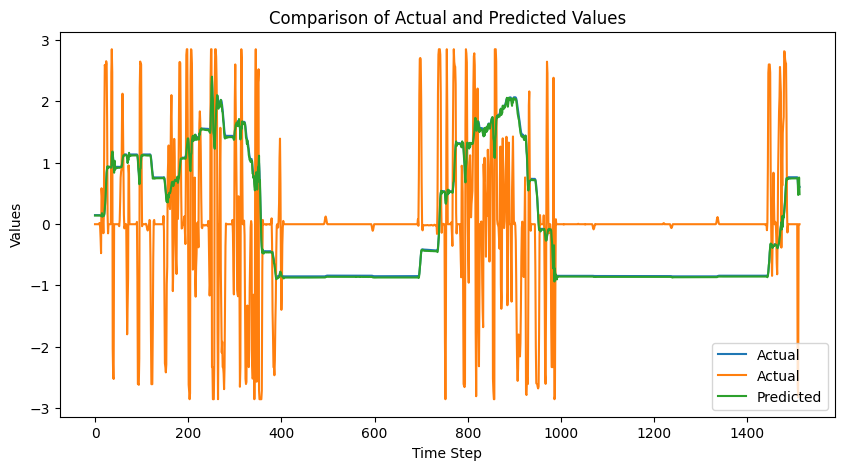

In [31]:
actuals, predictions = [], []

# Function to predict and visualize the results
def plot_predictions(model, loader):
    model.eval()
    with torch.no_grad():
        for seq, target in loader:
            seq, target = seq.float(), target.float()
            output = model(seq)
            actuals.extend(target.numpy())
            predictions.extend(output.numpy())

    # Plotting the first few sequences
    plt.figure(figsize=(10, 5))
    plt.plot(actuals, label='Actual')
    plt.plot(predictions, label='Predicted')
    plt.title('Comparison of Actual and Predicted Values')
    plt.xlabel('Time Step')
    plt.ylabel('Values')
    plt.legend()
    plt.show()

plot_predictions(model, vehicle_loader)

In [49]:
a=df2.std()['v_Vel']
a

15.81631182283838

NameError: name 'predicted_accelerations' is not defined

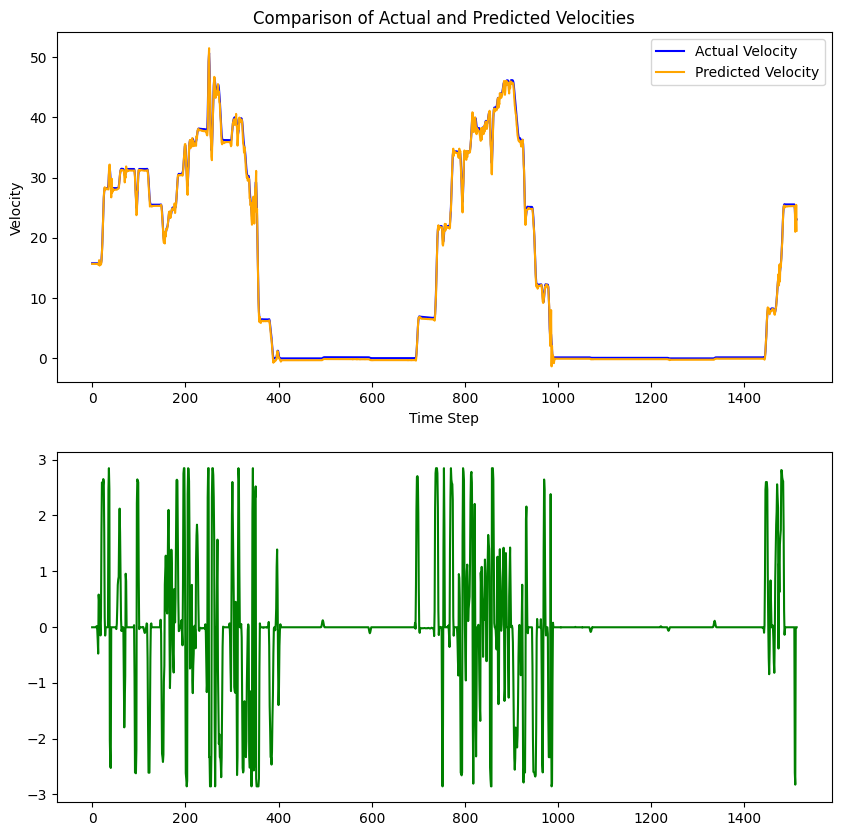

In [33]:
actuals = np.array(actuals)
predictions = np.array(predictions)
# actual_velocities, actual_accelerations = actuals[:, 0], actuals[:, 1]
# predicted_velocities, predicted_accelerations = predictions[:, 0], predictions[:, 1]
actual_velocities = actuals[:, 0]
predicted_velocities = predictions[:, 0]

#De-normalising Predictions
actual_velocities=actual_velocities*df2.std()['v_Vel']+df2.mean()['v_Vel']
predicted_velocities=predicted_velocities*(df2.std())['v_Vel']+df2.mean()['v_Vel']
# print(actual_velocities[0], actual_accelerations[0])
# print(predicted_velocities[0], predicted_accelerations[0])

fig, axs = plt.subplots(2, figsize=(10, 10))

# Plot actual values
axs[0].plot(actual_velocities, label='Actual Velocity', color='blue')
axs[0].plot(predicted_velocities, label='Predicted Velocity', color='orange')
axs[0].set_title('Comparison of Actual and Predicted Velocities')
axs[0].set_xlabel('Time Step')
axs[0].set_ylabel('Velocity')
axs[0].legend()

# Plot predicted values
axs[1].plot(actual_accelerations, label='Actual Acceleration', color='green')
axs[1].plot(predicted_accelerations, label='Predicted Acceleration', color='red')
axs[1].set_title('Comparison of Actual and Predicted Accelerations')
axs[1].set_xlabel('Time Step')
axs[1].set_ylabel('Acceleration')
axs[1].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [10]:
df2=df2[['Local_X','Local_Y','Lane_ID','Preceding','Following','v_Vel','v_Acc']]
normalized_data = (df2 - df2.mean()) / df2.std()
feature_columns = ['Local_X', 'Local_Y', 'v_Vel', 'v_Acc']
target_columns = ['v_Vel', 'v_Acc']

# Create sequences
sequence_length = 10  # For example, using the last 10 timesteps to predict the next

# Convert DataFrame to numpy and split features and target
feature_data = normalized_data[feature_columns].values
target_data = normalized_data[target_columns].values

sequences, targets = create_sequences(feature_data, target_data, sequence_length)

# 3. Split the Data (for example, 80-10-10 split)
train_size = int(len(sequences) * 0.9)
val_size = int(len(sequences) * 0.1)

train_sequences, train_targets = sequences[:train_size], targets[:train_size]
val_sequences, val_targets = sequences[train_size:train_size+val_size], targets[train_size:train_size+val_size]
test_sequences, test_targets = sequences[train_size+val_size:], targets[train_size+val_size:]

# 4. Convert to Tensors
train_sequences = torch.tensor(train_sequences, dtype=torch.float16)
train_targets = torch.tensor(train_targets, dtype=torch.float16)
val_sequences = torch.tensor(val_sequences, dtype=torch.float16)
val_targets = torch.tensor(val_targets, dtype=torch.float16)
test_sequences = torch.tensor(test_sequences, dtype=torch.float16)
test_targets = torch.tensor(test_targets, dtype=torch.float16)

loss_function = torch.nn.MSELoss()  # Mean Squared Error Loss for regression tasks
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)  # Adam optimizer

# Convert the sequences and targets into PyTorch Dataset and DataLoader
train_data = TensorDataset(train_sequences, train_targets)
val_data = TensorDataset(val_sequences, val_targets)

# Dataloader allows batch processing of the dataset
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

In [11]:
loss_function = torch.nn.MSELoss()  # Mean Squared Error Loss for regression tasks
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)  # Adam optimizer

# Convert the sequences and targets into PyTorch Dataset and DataLoader
train_data = TensorDataset(train_sequences, train_targets)
val_data = TensorDataset(val_sequences, val_targets)

# Dataloader allows batch processing of the dataset
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
# Evaluate on test data
def evaluate(model, test_loader, loss_function):
    model.eval()  # Set the model to evaluation mode
    test_losses = []
    with torch.no_grad():  # No gradients required for testing
        for seq, target in test_loader:
            seq, target = seq.float(), target.float()
            output = model(seq)
            loss = loss_function(output, target)
            test_losses.append(loss.item())
    return np.mean(test_losses)

test_data = TensorDataset(test_sequences, test_targets)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
test_loss = evaluate(model, test_loader, loss_function)
print(f'Test Loss: {test_loss:.4f}')

Test Loss: 0.0282


LSTM

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

input_size=input_dim
hidden_size = 64
num_layers = 2
output_size = 1
num_epochs = 100
learning_rate = 0.001

model = LSTM(input_size, hidden_size, num_layers, output_size).to(device)

